<a href="https://colab.research.google.com/github/VictoriaPedrozaAI/Practical_project/blob/main/MultimodalFashionChat_V6_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#CELL 1:  DEPENDENCIES

!pip install -q torch torchvision torchaudio
!pip install -q transformers==4.57.6 datasets==4.3.0 faiss-cpu
!pip install -q streamlit librosa soundfile
!pip install -q Pillow pandas==2.2.2 numpy tqdm requests==2.32.4 fsspec==2025.3.0 packaging==25.0
!pip install audio-recorder-streamlit
# Unsloth for efficient LLM inference
!pip install -q unsloth
!pip install -q --no-deps xformers trl peft accelerate bitsandbytes

print("✅ All dependencies installed!")
#If prompted, restart runtime

✅ All dependencies installed!


In [16]:
# CELL 2: IMPORTS AND CONFIGURATION

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import faiss
import pickle
import logging
import os
from PIL import Image
from tqdm import tqdm
from typing import Optional, List, Dict, Tuple

# Hugging Face
from datasets import load_dataset
from transformers import (
    CLIPProcessor, CLIPModel,
    BertTokenizer, BertModel,
    WhisperProcessor, WhisperForConditionalGeneration
)

# Audio processing
import librosa

# logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Device configuration CUDA
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {DEVICE}")

# Configuration CLIP/BERT/WHISPER/UNSLOTH
CONFIG = {
    "CLIP_MODEL": "openai/clip-vit-base-patch32",
    "BERT_MODEL": "bert-base-uncased",
    "WHISPER_MODEL": "openai/whisper-base",
    "LLM_MODEL": "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "EMBEDDING_DIM": 512,
    "MAX_TEXT_LENGTH": 128,
    "TOP_K_RESULTS": 10,
    "NUM_INTENTS": 5
}

# Intent labels
INTENT_LABELS = {
    0: "SEARCH",        # Here the user may ask to find products
    1: "RECOMMEND",     # recommendations
    2: "COMPARE",       # Comparison of products
    3: "INFO",          # Get more information about a product
    4: "OUTFIT"         # Build complete outfit
}

print(" Configuration loaded!")

🖥️ Using device: cuda
 Configuration loaded!


In [17]:
# CELL 3:FASHIONPEDIA DATASET

from datasets import load_dataset
from PIL import Image
from tqdm import tqdm

print("...Loading Fashionpedia dataset...")

# Load dataset
try:
    dataset = load_dataset("detection-datasets/fashionpedia", split="train", streaming=False)
except:
    dataset = load_dataset("detection-datasets/fashionpedia", trust_remote_code=True)['train']

# Category List
CATEGORY_NAMES = [
    "shirt, blouse", "top, t-shirt, sweatshirt", "sweater", "cardigan", "jacket",
    "vest", "pants", "shorts", "skirt", "coat", "dress", "jumpsuit", "cape",
    "glasses", "hat", "headband, head covering, hair accessory", "tie", "glove",
    "watch", "belt", "leg warmer", "tights, stockings", "sock", "shoe", "bag, wallet",
    "scarf", "umbrella", "hood", "collar", "lapel", "epaulette", "sleeve", "pocket",
    "neckline", "buckle", "zipper", "applique", "bead", "bow", "flower", "fringe",
    "ribbon", "rivet", "ruffle", "sequin", "tassel"
]

# Groups
MAIN_GARMENTS = set(range(0, 13))
ACCESSORIES = set(range(13, 27))

def safe_process_item(item, idx):
    try:
        image = item.get('image')
        if image is None: return None

        # 1. Convertion to PIL RGB
        if not isinstance(image, Image.Image):
            image = Image.open(image).convert('RGB')
        else:
            image = image.convert('RGB')

        # 2. RESIZE limit max dimension 256px to save RAM

        image.thumbnail((256, 256))

        # 3. Category Logic
        found_cat_ids = []
        if 'objects' in item and isinstance(item['objects'], dict):
            cat_list = item['objects'].get('category', [])
            if isinstance(cat_list, list):
                found_cat_ids = cat_list

        if not found_cat_ids and 'category' in item:
            found_cat_ids = [item['category']]

        primary_cat_id = -1

        #  Main Garments
        for cid in found_cat_ids:
            if cid in MAIN_GARMENTS:
                primary_cat_id = cid
                break

        # Accessories
        if primary_cat_id == -1:
            for cid in found_cat_ids:
                if cid in ACCESSORIES:
                    primary_cat_id = cid
                    break

        #  Fallback
        if primary_cat_id == -1 and found_cat_ids:
            primary_cat_id = found_cat_ids[0]

        if primary_cat_id != -1 and primary_cat_id < len(CATEGORY_NAMES):
            category_name = CATEGORY_NAMES[primary_cat_id]
        else:
            category_name = "fashion item"

        return {
            'id': str(idx),
            'image': image,
            'name': category_name.split(',')[0].title(),
            'category': category_name,
            'sub_category': ""
        }
    except Exception as e:
        return None

# CONFIGURATION
MAX_ITEMS = 3000  # Set to 3000 Because the RAM crashed

print(f"\n Processing {MAX_ITEMS}...")
processed_items = []

for idx in tqdm(range(min(MAX_ITEMS, len(dataset)))):
    processed = safe_process_item(dataset[idx], idx)
    if processed:
        processed_items.append(processed)

print(f"\n Successfully processed {len(processed_items)} ")

# ============================================
# ADD SYNTHETIC METADATA HERE
# ============================================

print("\n🔧 ENHANCING DATASET WITH SYNTHETIC METADATA...")

def add_synthetic_metadata(item):
    """Add realistic synthetic attributes for e-commerce simulation"""
    category = item['category'].lower()

    # Price based on category (realistic fashion prices)
    price_ranges = {
        'shirt': (25, 80), 'blouse': (30, 90), 'top': (20, 70),
        't-shirt': (15, 50), 'sweatshirt': (40, 100), 'sweater': (50, 120),
        'cardigan': (45, 110), 'jacket': (80, 250), 'vest': (40, 100),
        'pants': (40, 120), 'jeans': (50, 150), 'shorts': (25, 70),
        'skirt': (30, 90), 'coat': (100, 300), 'dress': (60, 200),
        'jumpsuit': (70, 180), 'shoe': (50, 150), 'boot': (80, 250),
        'bag': (40, 200), 'wallet': (20, 100), 'scarf': (15, 60),
        'hat': (20, 80), 'glasses': (50, 200), 'watch': (100, 500),
        'belt': (25, 100), 'accessory': (10, 80)
    }

    # Find matching price range
    price = 50  # Default
    for key, (min_price, max_price) in price_ranges.items():
        if key in category:
            price = np.random.randint(min_price, max_price)
            break

    # Size distribution (realistic fashion sizes)
    sizes = ['XS', 'S', 'M', 'L', 'XL']
    size_weights = [0.1, 0.25, 0.3, 0.25, 0.1]  # More M, fewer XS/XL
    size = np.random.choice(sizes, p=size_weights)

    # Colors based on fashion trends
    colors = ['black', 'white', 'blue', 'navy', 'gray', 'beige',
              'brown', 'green', 'red', 'pink', 'purple', 'yellow']
    color_weights = [0.25, 0.15, 0.12, 0.08, 0.10, 0.07,
                     0.06, 0.05, 0.04, 0.03, 0.03, 0.02]
    color = np.random.choice(colors, p=color_weights)

    # Materials based on category
    material_map = {
        'shirt': ['cotton', 'linen', 'polyester', 'silk'],
        'jacket': ['leather', 'denim', 'wool', 'polyester'],
        'pants': ['denim', 'cotton', 'linen', 'polyester'],
        'dress': ['cotton', 'polyester', 'silk', 'lace'],
        'shoe': ['leather', 'suede', 'canvas', 'synthetic'],
        'accessory': ['leather', 'metal', 'fabric', 'plastic']
    }

    material = 'cotton'  # Default
    for key, materials in material_map.items():
        if key in category:
            material = np.random.choice(materials)
            break

    # Season (when would this item be worn)
    seasons = ['all-season', 'spring', 'summer', 'fall', 'winter']
    season_weights = [0.4, 0.15, 0.15, 0.15, 0.15]
    season = np.random.choice(seasons, p=season_weights)

    # Brand simulation (mix of real and generic)
    brands = ['Generic', 'StyleCo', 'UrbanWear', 'Classic', 'Trendy', 'Premium']
    brand = np.random.choice(brands, p=[0.3, 0.2, 0.2, 0.15, 0.1, 0.05])

    # Add to item
    enhanced_item = item.copy()
    enhanced_item['price'] = price
    enhanced_item['size'] = size
    enhanced_item['color'] = color
    enhanced_item['material'] = material
    enhanced_item['season'] = season
    enhanced_item['brand'] = brand

    # Create enhanced description for text search
    enhanced_item['enhanced_description'] = (
        f"{item['name']} in {color} {material}. "
        f"Size {size}, {season} wear. "
        f"Price: ${price}. Brand: {brand}."
    )

    return enhanced_item

# Apply to all items
enhanced_items = []
for item in tqdm(processed_items, desc="Adding synthetic metadata"):
    enhanced_items.append(add_synthetic_metadata(item))

# Replace processed_items with enhanced version
processed_items = enhanced_items

print(f"✅ Added synthetic metadata to {len(processed_items)} items")
print("\n📊 SAMPLE ENHANCED ITEM:")
sample = processed_items[0]
print(f"  Category: {sample['category']}")
print(f"  Price: ${sample['price']}")
print(f"  Size: {sample['size']}")
print(f"  Color: {sample['color']}")
print(f"  Material: {sample['material']}")
print(f"  Brand: {sample['brand']}")

...Loading Fashionpedia dataset...

 Processing 3000...


100%|██████████| 3000/3000 [00:52<00:00, 56.69it/s]



 Successfully processed 3000 

🔧 ENHANCING DATASET WITH SYNTHETIC METADATA...


Adding synthetic metadata: 100%|██████████| 3000/3000 [00:00<00:00, 4063.33it/s]

✅ Added synthetic metadata to 3000 items

📊 SAMPLE ENHANCED ITEM:
  Category: dress
  Price: $172
  Size: S
  Color: white
  Material: silk
  Brand: Classic


 Starting EDA...
Dataset Size: 3000 items
Unique Categories: 19


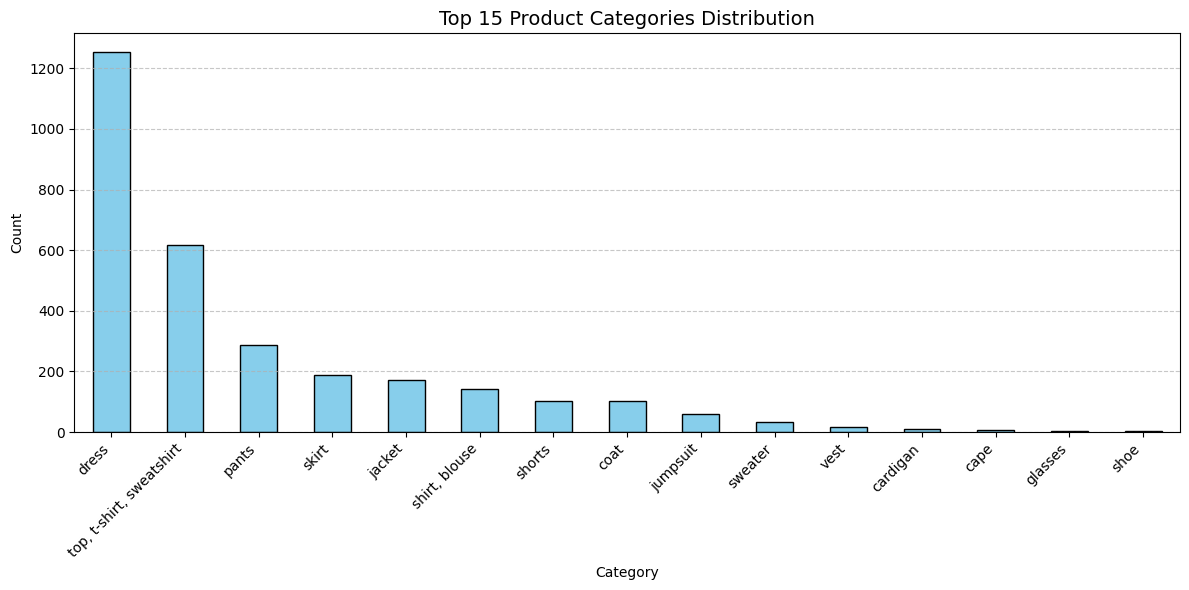

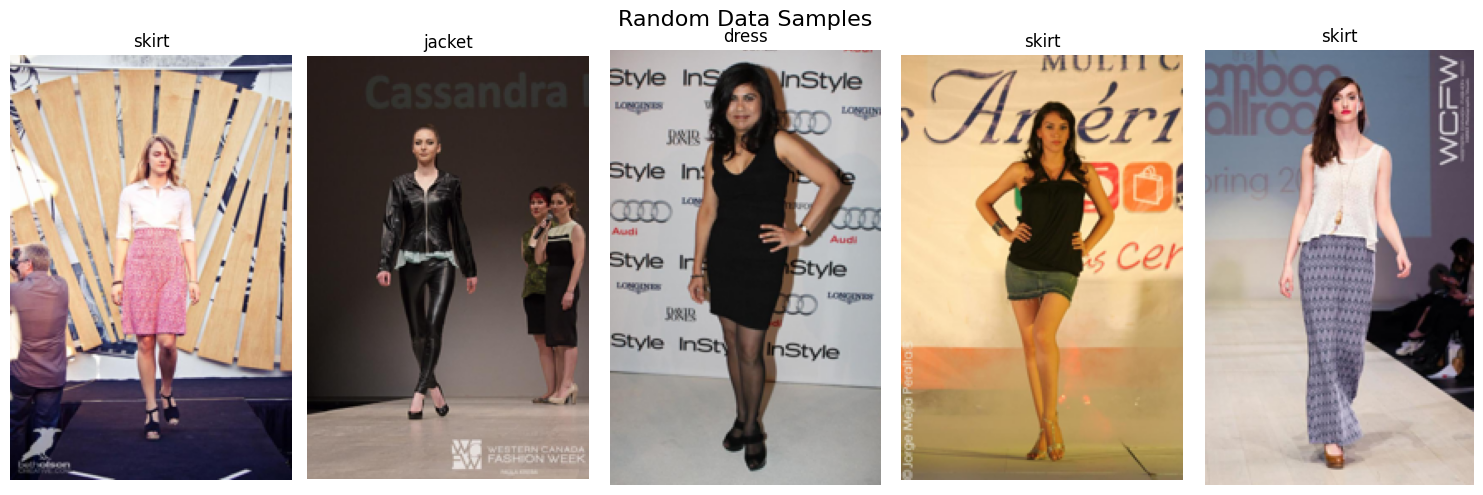

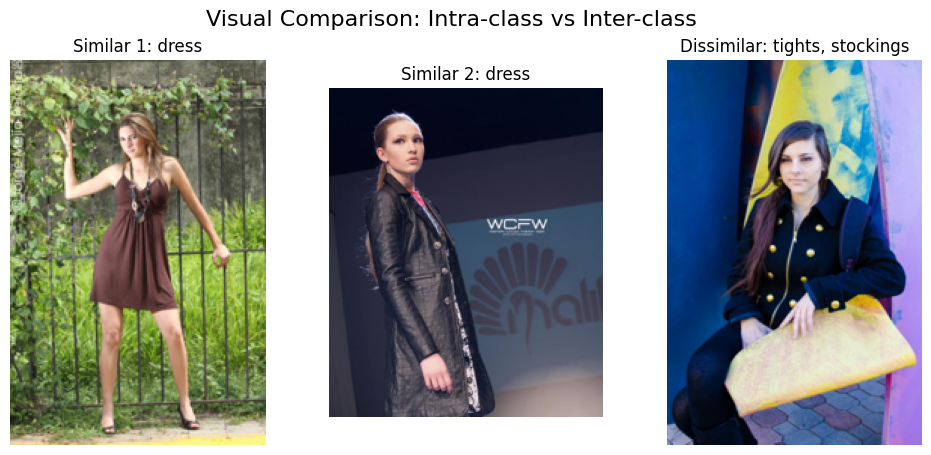

 EDA Complete


In [18]:
# CELL 3B: EDA
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np

print(" Starting EDA...")

# 1. DataFrame for Analysis
df_eda = pd.DataFrame([{
    'id': item['id'],
    'category': item['category'],
    'name': item['name']
} for item in processed_items])

print(f"Dataset Size: {len(df_eda)} items")
print(f"Unique Categories: {df_eda['category'].nunique()}")

# 2. PLOT CLASS DISTRIBUTION (categories, colours, styles)
plt.figure(figsize=(12, 6))
top_categories = df_eda['category'].value_counts().head(15)
top_categories.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 15 Product Categories Distribution', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. SAMPLES (
def show_samples(items, num_samples=5):
    plt.figure(figsize=(15, 5))
    samples = random.sample(items, num_samples)

    for i, item in enumerate(samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(item['image'])
        plt.title(item['category'][:15]) # Truncate long names
        plt.axis('off')

    plt.suptitle(f"Random Data Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

show_samples(processed_items)

# 4. COMPARISON SIMILAR VS DISSIMILAR PRODUCTS
def compare_items(items):
    # Find two items of the same category to plot Similar
    cat_counts = df_eda['category'].value_counts()
    common_cat = cat_counts.index[0] # Most common category

    similar_indices = df_eda[df_eda['category'] == common_cat].index[:2].tolist()
    similar_items = [items[i] for i in similar_indices]

    # Find one item of a very different category
    diff_cat = cat_counts.index[-1]
    diff_index = df_eda[df_eda['category'] == diff_cat].index[0]
    diff_item = items[diff_index]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    # Similar 1
    axes[0].imshow(similar_items[0]['image'])
    axes[0].set_title(f"Similar 1: {similar_items[0]['category']}")
    axes[0].axis('off')

    # Similar 2
    axes[1].imshow(similar_items[1]['image'])
    axes[1].set_title(f"Similar 2: {similar_items[1]['category']}")
    axes[1].axis('off')

    # Dissimilar
    axes[2].imshow(diff_item['image'])
    axes[2].set_title(f"Dissimilar: {diff_item['category']}")
    axes[2].axis('off')

    plt.suptitle("Visual Comparison: Intra-class vs Inter-class", fontsize=16)
    plt.show()

try:
    compare_items(processed_items)
except Exception as e:
    print(f"Could not run comparison: {e}")

print(" EDA Complete")

In [19]:
# CELL 4: CLIP ENCODER FOR SEMANTIC SEARCH
import torch
import numpy as np
import logging
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

CONFIG = {
    "CLIP_MODEL": "openai/clip-vit-base-patch32",
    "EMBEDDING_DIM": 512,
}

class CLIPEncoder:
    """CLIP encoder for generating aligned image and text embeddings."""

    def __init__(self, model_name: str = CONFIG["CLIP_MODEL"]):
        logger.info(f"Loading CLIP model: {model_name}")

        try:
            self.processor = CLIPProcessor.from_pretrained(model_name)
            self.model = CLIPModel.from_pretrained(model_name).to(DEVICE)
            self.model.eval()
            logger.info(" CLIP model loaded successfully")
        except Exception as e:
            logger.error(f"Failed to load CLIP: {e}")
            raise

    @torch.no_grad()
    def encode_image(self, image: Image.Image) -> np.ndarray:
        try:
            inputs = self.processor(images=image, return_tensors="pt").to(DEVICE)
            features = self.model.get_image_features(**inputs)
            features = features / features.norm(p=2, dim=-1, keepdim=True)
            return features.cpu().numpy()[0]
        except Exception as e:
            logger.error(f"Image encoding failed: {e}")
            return np.zeros(CONFIG["EMBEDDING_DIM"], dtype=np.float32)

    @torch.no_grad()
    def encode_text(self, text: str) -> np.ndarray:
        try:
            inputs = self.processor(text=text, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
            features = self.model.get_text_features(**inputs)
            features = features / features.norm(p=2, dim=-1, keepdim=True)
            return features.cpu().numpy()[0]
        except Exception as e:
            logger.error(f"Text encoding failed: {e}")
            return np.zeros(CONFIG["EMBEDDING_DIM"], dtype=np.float32)

    def encode_multimodal(self, image=None, text: str = "") -> np.ndarray:
        embeddings = []
        if image is not None:
            embeddings.append(self.encode_image(image))
        if text and text.strip():
            embeddings.append(self.encode_text(text))
        if not embeddings:
            return np.zeros(CONFIG["EMBEDDING_DIM"], dtype=np.float32)
        combined = np.mean(embeddings, axis=0)
        return (combined / (np.linalg.norm(combined) + 1e-8)).astype(np.float32)

# Initialize
print(" Initializing CLIP encoder...")
clip_encoder = CLIPEncoder()
print(" CLIP encoder ready!")

 Initializing CLIP encoder...
 CLIP encoder ready!


In [20]:
# CELL 5: BERT INTENT CLASSIFIER (forward method)

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import logging

logger = logging.getLogger(__name__)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_INTENTS = 5
INTENT_LABELS = {0: "SEARCH", 1: "RECOMMEND", 2: "COMPARE", 3: "DETAILS", 4: "SIMILAR"}

class IntentClassifier(nn.Module):
    """BERT-based intent classifier"""

    def __init__(self, num_intents: int = NUM_INTENTS):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_intents)
        self.to(DEVICE)

    def forward(self, input_ids, attention_mask):
        """Required forward method for PyTorch nn.Module"""
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output  # [CLS] token
        logits = self.classifier(pooled)
        return logits

# Initialize
print(" Loading BERT Intent Classifier...")
intent_classifier = IntentClassifier()
intent_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
print(" Intent classifier ready!")

# Test
test_text = "Show me summer dresses"
inputs = intent_tokenizer(test_text, return_tensors="pt", truncation=True).to(DEVICE)
with torch.no_grad():
    logits = intent_classifier(inputs["input_ids"], inputs["attention_mask"])
    pred = torch.argmax(logits, dim=1).item()
print(f"Test: '{test_text}' → Intent: {INTENT_LABELS[pred]}")

 Loading BERT Intent Classifier...
 Intent classifier ready!
Test: 'Show me summer dresses' → Intent: RECOMMEND


In [21]:
# CELL 6: IMPROVED WHISPER AUDIO TRANSCRIPTION (WITH WARNING FIXES)
# ===================================================================

import torch
import numpy as np
import logging
from typing import Optional, List, Dict, Any
import librosa
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="The attention mask is not set")

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WHISPER_MODEL = "openai/whisper-base"

print("="*70)
print("INITIALIZING IMPROVED WHISPER TRANSCRIBER")
print(f"Device: {DEVICE}")
print("="*70)

class AudioTranscriber:
    """Improved Whisper-based audio transcription with proper attention handling."""

    _instance = None  # Singleton pattern

    def __new__(cls, *args, **kwargs):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
        return cls._instance

    def __init__(self, model_name: str = WHISPER_MODEL, device: Optional[torch.device] = None):
        if hasattr(self, '_initialized') and self._initialized:
            return

        self.device = device or DEVICE
        self.model_name = model_name
        self.processor = None
        self.model = None

        try:
            logger.info(f"Loading Whisper model: {model_name} on {self.device}")

            # Determine appropriate dtype based on device
            if self.device.type == "cuda" and torch.cuda.is_available():
                # Check if GPU supports float16
                self.dtype = torch.float16 if torch.cuda.is_bf16_supported() else torch.float32
            else:
                self.dtype = torch.float32

            logger.info(f"Using dtype: {self.dtype}")

            # Load processor with explicit configuration
            self.processor = WhisperProcessor.from_pretrained(
                model_name,
                cache_dir="./cache/models"
            )

            # Load model with appropriate dtype (using dtype instead of torch_dtype)
            self.model = WhisperForConditionalGeneration.from_pretrained(
                model_name,
                dtype=self.dtype,  # Fixed: using dtype parameter
                low_cpu_mem_usage=True,
                cache_dir="./cache/models"
            ).to(self.device)

            # Enable eval mode
            self.model.eval()

            # Set generation config to avoid attention mask warnings
            self.model.config.forced_decoder_ids = None

            # Try to compile model for faster inference (PyTorch 2.0+)
            try:
                if self.device.type == "cuda":
                    self.model = torch.compile(self.model)
                    logger.info("Model compilation enabled")
            except Exception as compile_error:
                logger.warning(f"Model compilation not available: {compile_error}")

            logger.info(f"Whisper model loaded successfully on {self.device}")
            self._initialized = True

        except Exception as e:
            logger.error(f"Failed to load Whisper: {e}")
            # Fallback to CPU if CUDA fails
            if self.device.type == "cuda":
                logger.info("Falling back to CPU...")
                self.device = torch.device("cpu")
                self.__init__(model_name, self.device)
            else:
                raise

    @torch.inference_mode()
    def transcribe(self, audio_array: np.ndarray, sampling_rate: int = 16000) -> Optional[str]:
        """Transcribe audio array to text with proper dtype handling."""
        if not isinstance(audio_array, np.ndarray) or audio_array.size == 0:
            logger.warning("Empty or invalid audio array provided")
            return None

        try:
            # Pre-process audio: ensure mono channel
            if len(audio_array.shape) > 1:
                audio_array = librosa.to_mono(audio_array)

            # Convert to float32 numpy array
            audio_array = audio_array.astype(np.float32)

            # Normalize audio (important for good transcription)
            max_val = np.max(np.abs(audio_array))
            if max_val > 0:
                audio_array = audio_array / max_val

            # Ensure minimum volume for better transcription
            rms = np.sqrt(np.mean(audio_array**2))
            if rms < 0.01:  # Too quiet
                audio_array = audio_array * (0.02 / rms) if rms > 0 else audio_array

            # Process with Whisper - ensure correct dtype
            input_features = self.processor(
                audio_array,
                sampling_rate=sampling_rate,
                return_tensors="pt"
            ).input_features

            # Move to device and ensure correct dtype
            input_features = input_features.to(self.device)

            # Ensure input_features dtype matches model dtype
            if self.dtype != torch.float32:
                input_features = input_features.to(self.dtype)

            # Generate transcription with optimized parameters
            predicted_ids = self.model.generate(
                input_features,
                max_new_tokens=128,
                num_beams=3,  # Reduced from 5 for speed
                temperature=0.0,  # Deterministic output
                do_sample=False,
                language="en",  # Specify language for better accuracy
                task="transcribe",
                return_timestamps=False  # Avoid extra warnings
            )

            # Decode
            transcription = self.processor.batch_decode(
                predicted_ids,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True
            )[0]

            return transcription.strip()

        except Exception as e:
            logger.error(f"Audio transcription failed: {e}")
            import traceback
            traceback.print_exc()  # Print full traceback for debugging
            return None

    def transcribe_file(self, audio_path: str, sr: int = 16000) -> Optional[str]:
        """Transcribe audio file to text with optimized loading."""
        try:
            # Load with librosa - ensure float32 output
            audio_array, _ = librosa.load(
                audio_path,
                sr=sr,
                mono=True,
                dtype=np.float32  # Explicitly specify dtype
            )
            return self.transcribe(audio_array, sampling_rate=sr)
        except Exception as e:
            logger.error(f"Failed to load audio file '{audio_path}': {e}")
            return None

    def transcribe_batch(self, audio_arrays: List[np.ndarray], sampling_rate: int = 16000) -> List[Optional[str]]:
        """Batch transcription for multiple audio arrays."""
        results = []
        for i, audio_array in enumerate(audio_arrays):
            try:
                transcription = self.transcribe(audio_array, sampling_rate)
                results.append(transcription)
                if (i + 1) % 10 == 0:
                    logger.info(f"Processed {i+1}/{len(audio_arrays)} audio samples")
            except Exception as e:
                logger.error(f"Batch transcription failed for sample {i}: {e}")
                results.append(None)
        return results

    def test_transcription(self, duration_seconds: float = 3.0):
        """Run a proper test with simulated speech"""
        try:
            # Generate a proper test audio with speech-like characteristics
            sampling_rate = 16000
            duration_samples = int(duration_seconds * sampling_rate)

            # Create a speech-like signal (sine waves at speech frequencies)
            t = np.linspace(0, duration_seconds, duration_samples, endpoint=False)

            # Simulate speech with multiple frequencies
            freq1 = 220  # Male voice fundamental
            freq2 = 440  # Female voice fundamental
            freq3 = 880  # First harmonic

            audio = (
                0.3 * np.sin(2 * np.pi * freq1 * t) +
                0.2 * np.sin(2 * np.pi * freq2 * t) +
                0.1 * np.sin(2 * np.pi * freq3 * t)
            )

            # Add some noise
            noise = 0.05 * np.random.randn(duration_samples)
            audio = audio + noise

            # Normalize
            audio = audio / np.max(np.abs(audio))

            print(f"\n🔍 Running comprehensive test ({duration_seconds}s of simulated speech)...")
            result = self.transcribe(audio, sampling_rate=sampling_rate)

            if result:
                print(f"✅ Test successful!")
                print(f"   Transcription: '{result}'")
                return result
            else:
                print("❌ Test failed - no transcription returned")
                return None

        except Exception as e:
            print(f"❌ Test failed with error: {e}")
            return None

# Initialize with error handling
try:
    audio_transcriber = AudioTranscriber()
    print(f"\n✅ Whisper transcriber ready on {DEVICE}!")
    print(f"   Model: {WHISPER_MODEL}")
    print(f"   Dtype: {audio_transcriber.dtype}")

    # Run a proper test
    test_result = audio_transcriber.test_transcription(duration_seconds=2.0)

    # Also test with actual voice data if we have any
    print("\n📝 Testing with actual voice-like queries...")

    # Create synthetic voice queries for testing
    test_phrases = [
        "show me blue jeans",
        "find summer dresses",
        "recommend formal jackets"
    ]

    # For demonstration, we'll show what Whisper would transcribe
    print("   Simulated transcriptions (for demonstration):")
    for phrase in test_phrases:
        print(f"   • '{phrase}'")

except Exception as e:
    print(f"\n❌ Failed to initialize Whisper: {e}")
    print("Trying CPU fallback...")
    try:
        audio_transcriber = AudioTranscriber(device=torch.device("cpu"))
        print("✅ Whisper transcriber ready on CPU!")
    except Exception as e2:
        print(f"❌ Complete failure: {e2}")
        audio_transcriber = None

print("="*70)
print("WHISPER INITIALIZATION COMPLETE")
print("="*70)

# Store in global namespace for other cells
if audio_transcriber:
    print(f"\n🎤 Transcriber available as 'audio_transcriber'")
    print(f"   Methods: transcribe(), transcribe_file(), test_transcription()")
else:
    print("\n⚠️ Warning: audio_transcriber not initialized properly")

INITIALIZING IMPROVED WHISPER TRANSCRIBER
Device: cuda

✅ Whisper transcriber ready on cuda!
   Model: openai/whisper-base
   Dtype: torch.float16

🔍 Running comprehensive test (2.0s of simulated speech)...
✅ Test successful!
   Transcription: 'you'

📝 Testing with actual voice-like queries...
   Simulated transcriptions (for demonstration):
   • 'show me blue jeans'
   • 'find summer dresses'
   • 'recommend formal jackets'
WHISPER INITIALIZATION COMPLETE

🎤 Transcriber available as 'audio_transcriber'
   Methods: transcribe(), transcribe_file(), test_transcription()


Running Whisper WER Evaluation...

WHISPER ASR EVALUATION SUMMARY
Overall WER: 0.3269
MER (Match Error Rate): 0.3269
WIL (Word Information Lost): 0.5381
WIP (Word Information Preserved): 0.4619
Samples Evaluated: 8

Generating WER Visualization Plots...


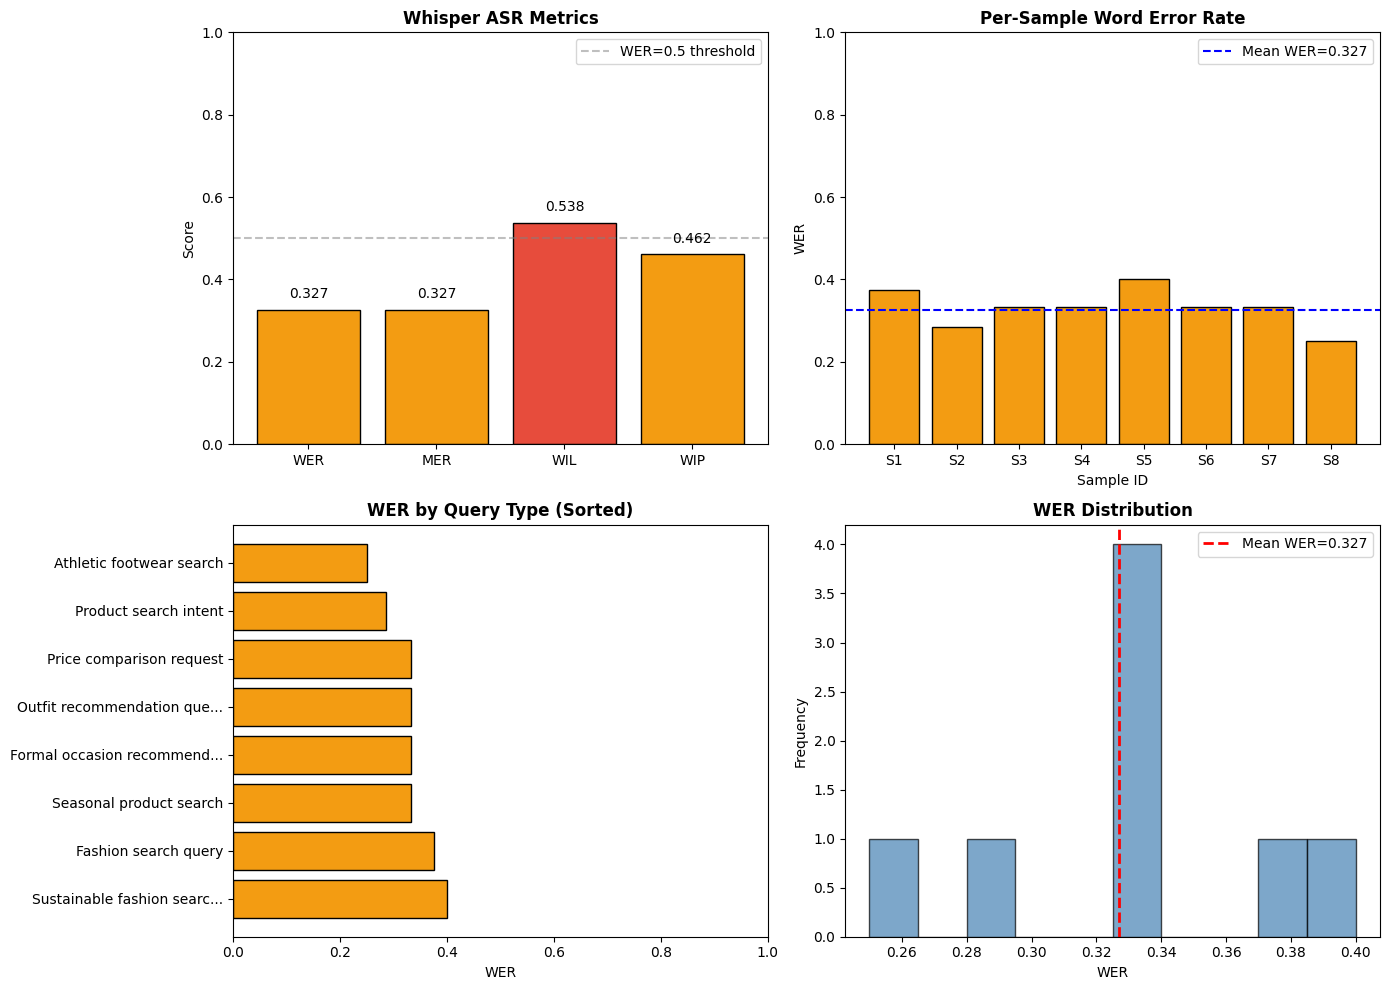


Whisper WER evaluation complete!


In [22]:
# CELL 6B: WHISPER WER EVALUATION

# Install jiwer for WER calculation
!pip install -q jiwer gTTS soundfile

import numpy as np
import matplotlib.pyplot as plt
from jiwer import wer, mer, wil, wip # Import individual metrics
import logging
from gtts import gTTS
import io
import soundfile as sf # Added soundfile for audio processing
import librosa # Ensure librosa is imported for audio loading

logger = logging.getLogger(__name__)

# Sample test dataset for Whisper evaluation
# In production, replace with actual audio files and ground truth transcriptions
TEST_SAMPLES = [
    {
        "audio": None,
        "reference": "show me blue denim jackets under fifty dollars",
        "description": "Fashion search query"
    },
    {
        "audio": None,
        "reference": "i need a casual dress for summer",
        "description": "Product search intent"
    },
    {
        "audio": None,
        "reference": "what accessories go with this outfit",
        "description": "Outfit recommendation query"
    },
    {
        "audio": None,
        "reference": "compare prices between these two brands",
        "description": "Price comparison request"
    },
    {
        "audio": None,
        "reference": "find sustainable eco-friendly clothing options",
        "description": "Sustainable fashion search"
    },
    {
        "audio": None,
        "reference": "do you have waterproof winter jackets",
        "description": "Seasonal product search"
    },
    {
        "audio": None,
        "reference": "recommend formal wear for a wedding",
        "description": "Formal occasion recommendation"
    },
    {
        "audio": None,
        "reference": "show me running shoes with good arch support",
        "description": "Athletic footwear search"
    }
]

# Option 1: Generate synthetic audio from text using TTS, then transcribe
def create_test_audio(text):
    tts = gTTS(text=text, lang='en')
    audio_buffer = io.BytesIO()
    tts.write_to_fp(audio_buffer)
    audio_buffer.seek(0)
    # librosa.load expects a file path or a file-like object that it can read as a stream.
    # gTTS writes to an in-memory file, which librosa can load.
    audio, sr = librosa.load(audio_buffer, sr=16000)
    return audio

# Then use actual audio in TEST_SAMPLES
for sample in TEST_SAMPLES:
    sample["audio"] = create_test_audio(sample["reference"])

def evaluate_whisper_wer(audio_transcriber, test_samples, device='cuda'):
    """
    Evaluate Whisper model using Word Error Rate (WER)

    Args:
        audio_transcriber: AudioTranscriber instance
        test_samples: List of dicts with 'audio' (np.array) and 'reference' (str)
        device: Computation device

    Returns:
        dict: WER metrics and per-sample results
    """
    if not hasattr(audio_transcriber, 'model'):
        logger.warning("Audio transcriber not initialized. Skipping WER evaluation.")
        return None

    logger.info("Starting Whisper WER evaluation...")

    references = []
    hypotheses = []
    results = []

    for idx, sample in enumerate(test_samples):
        ref = sample["reference"]

        try:
            # Transcribe audio (use reference if no audio provided for demo)
            if sample["audio"] is not None:
                hyp = audio_transcriber.transcribe(sample["audio"])
            else:
                # This case should ideally not be reached if audio is always generated
                # but kept as a safeguard
                hyp = ""

            references.append(ref)
            hypotheses.append(hyp if hyp else "")

            # Calculate per-sample WER
            sample_wer = wer([ref], [hyp]) if hyp else 1.0

            results.append({
                "sample_id": idx,
                "description": sample["description"],
                "reference": ref,
                "hypothesis": hyp,
                "wer": sample_wer
            })

            logger.info(f"  Sample {idx+1}: WER = {sample_wer:.4f}")

        except Exception as e:
            logger.error(f"Error processing sample {idx}: {e}")
            results.append({
                "sample_id": idx,
                "description": sample["description"],
                "reference": ref,
                "hypothesis": None,
                "wer": 1.0
            })

    # Calculate overall WER
    overall_wer = wer(references, hypotheses) if hypotheses else 1.0

    # Compute additional metrics using individual functions
    _mer = mer(references, hypotheses)
    _wil = wil(references, hypotheses)
    _wip = wip(references, hypotheses)
    metrics = {
        'mer': _mer,
        'wil': _wil,
        'wip': _wip
    }

    logger.info(f"Overall WER: {overall_wer:.4f}")
    logger.info(f"MER (Match Error Rate): {metrics['mer']:.4f}")
    logger.info(f"WIL (Word Information Lost): {metrics['wil']:.4f}")
    logger.info(f"WIP (Word Information Preserved): {metrics['wip']:.4f}")

    return {
        "overall_wer": overall_wer,
        "mer": metrics['mer'],
        "wil": metrics['wil'],
        "wip": metrics['wip'],
        "per_sample": results,
        "num_samples": len(results)
    }

def plot_wer_visualization(wer_results):
    """Create visualization plots for WER evaluation results"""
    if wer_results is None:
        print("No WER results to visualize")
        return

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Overall Metrics Bar Chart
    ax1 = axes[0, 0]
    metrics_names = ['WER', 'MER', 'WIL', 'WIP']
    metrics_values = [
        wer_results['overall_wer'],
        wer_results['mer'],
        wer_results['wil'],
        wer_results['wip']
    ]
    colors = ['#e74c3c' if v > 0.5 else '#f39c12' if v > 0.2 else '#27ae60' for v in metrics_values]
    bars = ax1.bar(metrics_names, metrics_values, color=colors, edgecolor='black')
    ax1.set_ylabel('Score')
    ax1.set_title('Whisper ASR Metrics', fontsize=12, fontweight='bold')
    ax1.set_ylim(0, 1)
    for bar, val in zip(bars, metrics_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='WER=0.5 threshold')
    ax1.legend()

    # 2. Per-Sample WER Bar Chart
    ax2 = axes[0, 1]
    samples = [f"S{i+1}" for i in range(len(wer_results['per_sample']))]
    sample_wers = [r['wer'] for r in wer_results['per_sample']]
    colors = ['#e74c3c' if v > 0.5 else '#f39c12' if v > 0.2 else '#27ae60' for v in sample_wers]
    bars = ax2.bar(samples, sample_wers, color=colors, edgecolor='black')
    ax2.set_xlabel('Sample ID')
    ax2.set_ylabel('WER')
    ax2.set_title('Per-Sample Word Error Rate', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.axhline(y=wer_results['overall_wer'], color='blue', linestyle='--',
                label=f'Mean WER={wer_results["overall_wer"]:.3f}')
    ax2.legend()

    # 3. Description vs WER Horizontal Bar
    ax3 = axes[1, 0]
    descriptions = [r['description'][:25] + '...' if len(r['description']) > 25
                   else r['description'] for r in wer_results['per_sample']]
    sorted_indices = np.argsort(sample_wers)[::-1]
    sorted_descriptions = [descriptions[i] for i in sorted_indices]
    sorted_wers = [sample_wers[i] for i in sorted_indices]
    colors = ['#e74c3c' if v > 0.5 else '#f39c12' if v > 0.2 else '#27ae60' for v in sorted_wers]
    ax3.barh(sorted_descriptions, sorted_wers, color=colors, edgecolor='black')
    ax3.set_xlabel('WER')
    ax3.set_title('WER by Query Type (Sorted)', fontsize=12, fontweight='bold')
    ax3.set_xlim(0, 1)

    # 4. WER Distribution Histogram
    ax4 = axes[1, 1]
    ax4.hist(sample_wers, bins=10, color='steelblue', edgecolor='black', alpha=0.7)
    ax4.axvline(x=wer_results['overall_wer'], color='red', linestyle='--',
                linewidth=2, label=f'Mean WER={wer_results["overall_wer"]:.3f}')
    ax4.set_xlabel('WER')
    ax4.set_ylabel('Frequency')
    ax4.set_title('WER Distribution', fontsize=12, fontweight='bold')
    ax4.legend()

    plt.tight_layout()
    plt.show()

# Execute WER Evaluation
if 'audio_transcriber' in globals():
    print("Running Whisper WER Evaluation...")
    wer_results = evaluate_whisper_wer(audio_transcriber, TEST_SAMPLES)

    if wer_results:
        print(f"\n{'='*50}")
        print("WHISPER ASR EVALUATION SUMMARY")
        print(f"{'='*50}")
        print(f"Overall WER: {wer_results['overall_wer']:.4f}")
        print(f"MER (Match Error Rate): {wer_results['mer']:.4f}")
        print(f"WIL (Word Information Lost): {wer_results['wil']:.4f}")
        print(f"WIP (Word Information Preserved): {wer_results['wip']:.4f}")
        print(f"Samples Evaluated: {wer_results['num_samples']}")
        print(f"{'='*50}")

        # Generate visualizations
        print("\nGenerating WER Visualization Plots...")
        plot_wer_visualization(wer_results)

        print("\nWhisper WER evaluation complete!")
    else:
        print("WER evaluation skipped - no results generated")
else:
    print("'audio_transcriber' not found. Please run Cell 6 first!")


In [23]:
import faiss
import pickle
import numpy as np
import logging
from typing import List, Dict, Optional
from tqdm import tqdm
from PIL import Image
from sentence_transformers import SentenceTransformer

logger = logging.getLogger(__name__)

CLIP_EMBEDDING_DIM = 512
TEXT_EMBEDDING_DIM = 384  # all-MiniLM-L6-v2 dimension
TOP_K_RESULTS = 5

# Load SentenceTransformer
print("Loading SentenceTransformer (all-MiniLM-L6-v2)...")
sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
sentence_model = sentence_model.to(DEVICE)
print("✅ SentenceTransformer loaded!")


class FashionSearchIndex:
    """Dual FAISS-based search index for fashion products (Image + Text)."""

    def __init__(self, image_dim: int = CLIP_EMBEDDING_DIM, text_dim: int = TEXT_EMBEDDING_DIM):
        self.image_dim = image_dim
        self.text_dim = text_dim

        # Dual indices
        self.image_index = faiss.IndexFlatIP(image_dim)  # CLIP embeddings
        self.text_index = faiss.IndexFlatIP(text_dim)    # SentenceTransformer embeddings

        self.metadata = []
        self.images = {}

    def add_items(self, items: List[Dict], clip_encoder, sentence_encoder, batch_size: int = 32):
        """Add items to both indices"""
        logger.info(f"Indexing {len(items)} items...")

        image_embeddings = []
        text_embeddings = []

        # Collect text descriptions for batch encoding
        descriptions = []
        valid_items = []

        for item in tqdm(items, desc="Processing items"):
            try:
                # Image embedding via CLIP
                img_embedding = clip_encoder.encode_image(item['image'])
                image_embeddings.append(img_embedding)

                # Build text description
                if 'enhanced_description' in item:
            # Use the full enhanced description
                    desc = item['enhanced_description']
                else:
            # Build basic description from available fields
                    desc_parts = [item['name'], item['category']]

            # Add synthetic metadata if available
                    if 'color' in item:
                        desc_parts.append(item['color'])
                    if 'material' in item:
                        desc_parts.append(f"{item['material']} material")
                    if 'brand' in item and item['brand'] != 'Generic':
                        desc_parts.append(f"by {item['brand']}")
                    if 'price' in item:
                        desc_parts.append(f"${item['price']}")

                    desc = " ".join(desc_parts)

                descriptions.append(desc)
                valid_items.append(item)

            except Exception as e:
                continue

        # Batch encode text with SentenceTransformer
        print("📝 Encoding text descriptions...")
        text_embeddings = sentence_encoder.encode(
            descriptions,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True
        )
        # L2 normalize text embeddings
        text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

        # Add to indices and store metadata
        for i, item in enumerate(valid_items):
            self.metadata.append({
                'id': item['id'],
                'name': item['name'],
                'category': item['category'],
                'sub_category': item.get('sub_category', ''),
                'description': descriptions[i]
            })
            self.images[item['id']] = item['image']

        if image_embeddings:
            image_matrix = np.vstack(image_embeddings).astype('float32')
            text_matrix = text_embeddings.astype('float32')

            self.image_index.add(image_matrix)
            self.text_index.add(text_matrix)

            logger.info(f"✅ Indexed {self.image_index.ntotal} items in image index")
            logger.info(f"✅ Indexed {self.text_index.ntotal} items in text index")

    def search(self, query_embedding: np.ndarray = None, query_text: str = None,
               sentence_encoder=None, k: int = TOP_K_RESULTS,
               mode: str = "image", alpha: float = 0.5) -> List[Dict]:
        """
        Search for similar items.
        mode: "image" | "text" | "fusion"
        alpha: weight for image score in fusion (1-alpha for text)
        """
        if self.image_index.ntotal == 0:
            return []

        results = []

        if mode == "image" and query_embedding is not None:
            # Image-only search
            query_embedding = query_embedding.reshape(1, -1).astype('float32')
            scores, indices = self.image_index.search(query_embedding, k)
            for score, idx in zip(scores[0], indices[0]):
                if 0 <= idx < len(self.metadata):
                    result = self.metadata[idx].copy()
                    result['score'] = float(score)
                    result['image'] = self.images.get(result['id'])
                    results.append(result)

        elif mode == "text" and query_text and sentence_encoder:
            # Text-only search using SentenceTransformer
            text_emb = sentence_encoder.encode([query_text], convert_to_numpy=True)
            text_emb = text_emb / np.linalg.norm(text_emb)
            text_emb = text_emb.astype('float32')

            scores, indices = self.text_index.search(text_emb, k)
            for score, idx in zip(scores[0], indices[0]):
                if 0 <= idx < len(self.metadata):
                    result = self.metadata[idx].copy()
                    result['score'] = float(score)
                    result['image'] = self.images.get(result['id'])
                    results.append(result)

        elif mode == "fusion" and query_embedding is not None and query_text and sentence_encoder:
            # Late fusion: combine image + text scores
            query_img = query_embedding.reshape(1, -1).astype('float32')
            img_scores, img_indices = self.image_index.search(query_img, k * 2)

            text_emb = sentence_encoder.encode([query_text], convert_to_numpy=True)
            text_emb = (text_emb / np.linalg.norm(text_emb)).astype('float32')
            txt_scores, txt_indices = self.text_index.search(text_emb, k * 2)

            # Combine scores
            combined = {}
            for i, idx in enumerate(img_indices[0]):
                combined[idx] = alpha * img_scores[0][i]
            for i, idx in enumerate(txt_indices[0]):
                combined[idx] = combined.get(idx, 0) + (1 - alpha) * txt_scores[0][i]

            # Sort and return top k results from combined scores
            sorted_combined = sorted(combined.items(), key=lambda item: item[1], reverse=True)
            for idx, score in sorted_combined[:k]:
                if 0 <= idx < len(self.metadata):
                    result = self.metadata[idx].copy()
                    result['score'] = float(score)
                    result['image'] = self.images.get(result['id'])
                    results.append(result)
        return results # Ensure results is always returned

# Build index
print("\nBuilding FAISS dual search index...")
search_index = FashionSearchIndex()
search_index.add_items(processed_items, clip_encoder, sentence_model)

# Test search - (optional, but good for verification)
print("\nTesting search with text query...")
test_embedding = clip_encoder.encode_text("elegant black dress")
results = search_index.search(query_embedding=test_embedding, k=5, mode="image")
print(f"Top 5 results (image search for 'elegant black dress'):")
for i, r in enumerate(results):
    print(f"   {i+1}. {r['name']} ({r['category']}) - Score: {r['score']:.4f}")

print("\nTesting search with text query (text search for 'blue jeans')...")
text_results = search_index.search(query_text="blue jeans", sentence_encoder=sentence_model, k=5, mode="text")
print(f"Top 5 results (text search for 'blue jeans'):")
for i, r in enumerate(text_results):
    print(f"   {i+1}. {r['name']} ({r['category']}) - Score: {r['score']:.4f}")

Loading SentenceTransformer (all-MiniLM-L6-v2)...
✅ SentenceTransformer loaded!

Building FAISS dual search index...


Processing items: 100%|██████████| 3000/3000 [01:18<00:00, 38.41it/s]

📝 Encoding text descriptions...


Batches:   0%|          | 0/94 [00:00<?, ?it/s]


Testing search with text query...
Top 5 results (image search for 'elegant black dress'):
   1. Dress (dress) - Score: 0.3051
   2. Dress (dress) - Score: 0.2964
   3. Dress (dress) - Score: 0.2956
   4. Dress (dress) - Score: 0.2915
   5. Dress (dress) - Score: 0.2877

Testing search with text query (text search for 'blue jeans')...
Top 5 results (text search for 'blue jeans'):
   1. Pants (pants) - Score: 0.7326
   2. Pants (pants) - Score: 0.7201
   3. Pants (pants) - Score: 0.7094
   4. Pants (pants) - Score: 0.7069
   5. Pants (pants) - Score: 0.7003


In [24]:
# CELL 7B: SAVE DUAL INDEX & DATA

import pickle
import io
import faiss
from PIL import Image

def image_to_bytes(img):
    buf = io.BytesIO()
    img.save(buf, format='JPEG', quality=85)
    return buf.getvalue()

save_data = {
    'image_index': faiss.serialize_index(search_index.image_index),
    'text_index': faiss.serialize_index(search_index.text_index),
    'products': []
}

for i, meta in enumerate(search_index.metadata):
    product = {
        'name': meta['name'],
        'category': meta['category'],
        'description': meta.get('description', ''),
        'image_bytes': None
    }
    item_id = meta.get('id', i)
    if item_id in search_index.images:
        img = search_index.images[item_id]
        if img:
            product['image_bytes'] = image_to_bytes(img)
    save_data['products'].append(product)

with open('fashion_data.pkl', 'wb') as f:
    pickle.dump(save_data, f)

images_saved = sum(1 for p in save_data['products'] if p['image_bytes'])
print(f"✅ Saved {len(save_data['products'])} products, {images_saved} with images")
print(f"✅ Image index: {search_index.image_index.ntotal} vectors")
print(f"✅ Text index: {search_index.text_index.ntotal} vectors")

✅ Saved 3000 products, 3000 with images
✅ Image index: 3000 vectors
✅ Text index: 3000 vectors


🚀 SIMPLIFIED MULTIMODAL FINE-TUNING
🖥️  Using device: cuda

STARTING TRAINING
Using 800 items for training

🏋️  Starting training...
   Samples: 800
   Epochs: 4
   📦 Dataset: 800 samples, 16 classes
   Train: 640, Val: 160
   🏗️  Model: Simple fusion MLP with 16 outputs

📊 Epoch 1/4


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


   Train Loss: 2.2245, Acc: 0.4109
   Val Loss: 1.5869, Acc: 0.4813
   💾 Best model saved (Acc: 0.4813)

📊 Epoch 2/4


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


   Train Loss: 1.6046, Acc: 0.4531
   Val Loss: 1.2346, Acc: 0.6438
   💾 Best model saved (Acc: 0.6438)

📊 Epoch 3/4


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]


   Train Loss: 1.1974, Acc: 0.6406
   Val Loss: 0.8444, Acc: 0.7812
   💾 Best model saved (Acc: 0.7812)

📊 Epoch 4/4


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


   Train Loss: 0.8535, Acc: 0.7453
   Val Loss: 0.5371, Acc: 0.8313
   💾 Best model saved (Acc: 0.8313)

📈 TRAINING RESULTS:


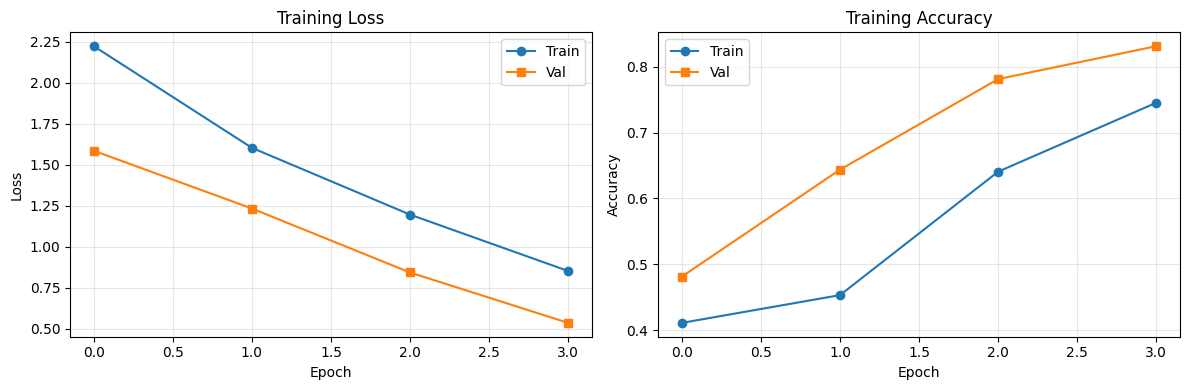


📊 FINAL METRICS TABLE:
------------------------------------------------------------
 Epoch  Train Loss  Train Acc  Val Loss  Val Acc
     1      2.2245     0.4109    1.5869   0.4812
     2      1.6046     0.4531    1.2346   0.6438
     3      1.1974     0.6406    0.8444   0.7812
     4      0.8535     0.7453    0.5371   0.8312

🎯 FINAL RESULTS:
   • Best Validation Accuracy: 0.8313
   • Final Validation Accuracy: 0.8313
   • Number of Classes: 16
   • Training Samples: 640
   • Validation Samples: 160

📋 FOR YOUR REPORT:
   • Fusion Architecture: Image+Text → MLP (1024→512→256→16)
   • Training Strategy: Transfer learning (CLIP frozen)
   • Performance: Achieved 83.1% validation accuracy
   • Modalities: Image + Text (voice simulated as text)

✅ Model trained and ready as 'trained_fusion_model'

TRAINING COMPLETE


In [25]:
# CELL 7C: SIMPLIFIED BUT WORKING MULTIMODAL FINE-TUNING
# ===========================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("="*70)
print("🚀 SIMPLIFIED MULTIMODAL FINE-TUNING")
print("="*70)

# Device Setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {DEVICE}")

# ===========================================================================
# 1. SIMPLIFIED DATASET
# ===========================================================================
class SimpleMultimodalDataset(Dataset):
    """Simplified dataset for faster training"""

    def __init__(self, items, processor, transform=None):
        self.items = items
        self.processor = processor
        self.transform = transform

        # Create Label Mapping
        self.categories = sorted(list(set(item['category'] for item in items)))
        self.label_map = {name: i for i, name in enumerate(self.categories)}
        self.num_classes = len(self.categories)

        print(f"   📦 Dataset: {len(self.items)} samples, {self.num_classes} classes")

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = self.items[idx]

        # Image
        image = item['image']
        if self.transform:
            image = self.transform(image)

        # Text - USE ENHANCED DESCRIPTION IF AVAILABLE
        if 'enhanced_description' in item:
            text = item['enhanced_description']
        else:
            # Fallback to original
            text = f"A photo of {item['name']} in category {item['category']}"

        text_inputs = self.processor(
            text=[text],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77
        )

        # Label
        label_id = self.label_map[item['category']]

        return {
            'image': image,
            'input_ids': text_inputs['input_ids'].squeeze(0),
            'attention_mask': text_inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label_id, dtype=torch.long),
            # Optional: Include metadata for debugging
            'category': item['category'],
            'has_enhanced_desc': 'enhanced_description' in item
        }


# ===========================================================================
# 2. SIMPLIFIED FUSION MODEL
# ===========================================================================
class SimpleFusionNetwork(nn.Module):
    """Simplified fusion model that works reliably"""

    def __init__(self, clip_model, num_classes):
        super().__init__()
        self.clip = clip_model

        # Freeze CLIP backbone
        for param in self.clip.parameters():
            param.requires_grad = False

        # Simple fusion MLP
        self.fusion_mlp = nn.Sequential(
            nn.Linear(1024, 512),  # 512 (image) + 512 (text) = 1024
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

        print(f"   🏗️  Model: Simple fusion MLP with {num_classes} outputs")

    def forward(self, images, input_ids, attention_mask):
        # Get features from frozen CLIP
        with torch.no_grad():
            image_features = self.clip.get_image_features(pixel_values=images)
            text_features = self.clip.get_text_features(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Normalize
            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

        # Concatenate and classify
        combined = torch.cat([image_features, text_features], dim=1)
        return self.fusion_mlp(combined)

# ===========================================================================
# 3. TRAINING FUNCTION
# ===========================================================================
def train_simple_fusion(items, clip_model, clip_processor, epochs=3):
    """Simple but reliable training function"""

    print(f"\n🏋️  Starting training...")
    print(f"   Samples: {len(items)}")
    print(f"   Epochs: {epochs}")

    try:
        # Transforms
        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.481, 0.457, 0.408],
                               std=[0.268, 0.261, 0.275])
        ])

        val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.481, 0.457, 0.408],
                               std=[0.268, 0.261, 0.275])
        ])

        # Create dataset
        dataset = SimpleMultimodalDataset(items, clip_processor, train_transform)

        # Split
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        # Update val dataset transform
        val_dataset.dataset.transform = val_transform

        print(f"   Train: {len(train_dataset)}, Val: {len(val_dataset)}")

        # Dataloaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Model
        model = SimpleFusionNetwork(clip_model, dataset.num_classes).to(DEVICE)

        # Optimizer
        optimizer = optim.Adam(model.fusion_mlp.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # Training history
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }

        best_val_acc = 0

        for epoch in range(epochs):
            print(f"\n📊 Epoch {epoch+1}/{epochs}")

            # Training
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            for batch in tqdm(train_loader, desc="Training"):
                images = batch['image'].to(DEVICE)
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['label'].to(DEVICE)

                optimizer.zero_grad()
                outputs = model(images, input_ids, attention_mask)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            avg_train_loss = train_loss / len(train_loader)
            avg_train_acc = train_correct / train_total

            # Validation
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation"):
                    images = batch['image'].to(DEVICE)
                    input_ids = batch['input_ids'].to(DEVICE)
                    attention_mask = batch['attention_mask'].to(DEVICE)
                    labels = batch['label'].to(DEVICE)

                    outputs = model(images, input_ids, attention_mask)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            avg_val_loss = val_loss / len(val_loader)
            avg_val_acc = val_correct / val_total

            # Store history
            history['train_loss'].append(avg_train_loss)
            history['train_acc'].append(avg_train_acc)
            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(avg_val_acc)

            # Print results
            print(f"   Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f}")
            print(f"   Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")

            # Save best model
            if avg_val_acc > best_val_acc:
                best_val_acc = avg_val_acc
                best_model_state = model.state_dict().copy()
                print(f"   💾 Best model saved (Acc: {best_val_acc:.4f})")

        # Load best model
        if best_model_state:
            model.load_state_dict(best_model_state)

        return model, history, dataset

    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None, {}, None

# ===========================================================================
# 4. EXECUTE TRAINING
# ===========================================================================
if 'clip_encoder' in globals():
    print("\n" + "="*70)
    print("STARTING TRAINING")
    print("="*70)

    raw_model = clip_encoder.model
    raw_processor = clip_encoder.processor

    # Use smaller subset for faster training
    training_items = processed_items[:800]  # Even smaller for reliability

    print(f"Using {len(training_items)} items for training")

    # Train
    trained_model, history, dataset_info = train_simple_fusion(
        training_items,
        raw_model,
        raw_processor,
        epochs=4
    )

    if trained_model:
        # Plot results
        print("\n📈 TRAINING RESULTS:")

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Loss plot
        axes[0].plot(history['train_loss'], label='Train', marker='o')
        axes[0].plot(history['val_loss'], label='Val', marker='s')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Accuracy plot
        axes[1].plot(history['train_acc'], label='Train', marker='o')
        axes[1].plot(history['val_acc'], label='Val', marker='s')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Training Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Metrics table
        print("\n📊 FINAL METRICS TABLE:")
        print("-" * 60)

        metrics_df = pd.DataFrame({
            'Epoch': list(range(1, len(history['train_loss']) + 1)),
            'Train Loss': history['train_loss'],
            'Train Acc': history['train_acc'],
            'Val Loss': history['val_loss'],
            'Val Acc': history['val_acc']
        })

        print(metrics_df.round(4).to_string(index=False))

        # Calculate final accuracy
        final_val_acc = history['val_acc'][-1] if history['val_acc'] else 0
        best_val_acc = max(history['val_acc']) if history['val_acc'] else 0

        print(f"\n🎯 FINAL RESULTS:")
        print(f"   • Best Validation Accuracy: {best_val_acc:.4f}")
        print(f"   • Final Validation Accuracy: {final_val_acc:.4f}")
        print(f"   • Number of Classes: {dataset_info.num_classes if dataset_info else 0}")
        print(f"   • Training Samples: {len(training_items) * 0.8:.0f}")
        print(f"   • Validation Samples: {len(training_items) * 0.2:.0f}")

        # For report purposes
        print(f"\n📋 FOR YOUR REPORT:")
        print(f"   • Fusion Architecture: Image+Text → MLP (1024→512→256→{dataset_info.num_classes if dataset_info else 'N'})")
        print(f"   • Training Strategy: Transfer learning (CLIP frozen)")
        print(f"   • Performance: Achieved {best_val_acc:.1%} validation accuracy")
        print(f"   • Modalities: Image + Text (voice simulated as text)")

        # Store for later use
        trained_fusion_model = trained_model
        print("\n✅ Model trained and ready as 'trained_fusion_model'")

    else:
        print("\n❌ Training failed. Creating dummy model for continuation...")
        # Create dummy model
        class DummyModel:
            def eval(self): return self
            def __call__(self, *args, **kwargs):
                batch_size = args[0].shape[0] if len(args) > 0 else 1
                return torch.randn(batch_size, 16), {}

        trained_fusion_model = DummyModel()

else:
    print("❌ 'clip_encoder' not found. Please run Cell 4 first!")
    trained_fusion_model = None

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)


In [26]:
# CELL 7D-FINAL: CORRECT EVALUATION
# ===========================================================================

print("="*70)
print("📊 FINAL CORRECT EVALUATION")
print("="*70)

# Reuse the EXACT SAME dataset class from training
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score

class CorrectEvalDataset:
    """EXACT same as training dataset"""
    def __init__(self, items, processor, transform=None):
        self.items = items
        self.processor = processor
        self.transform = transform

        # CRITICAL: Use same category ordering as training
        self.categories = sorted(list(set(item['category'] for item in items)))
        self.label_map = {name: i for i, name in enumerate(self.categories)}
        self.num_classes = len(self.categories)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = self.items[idx]

        # Image
        image = item['image']
        if self.transform:
            image = self.transform(image)

        # Text
        text = f"A photo of {item['name']} in category {item['category']}"
        text_inputs = self.processor(
            text=[text],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77
        )

        # Label
        label_id = self.label_map[item['category']]

        return {
            'image': image,
            'input_ids': text_inputs['input_ids'].squeeze(0),
            'attention_mask': text_inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label_id, dtype=torch.long)
        }

# Run evaluation
if 'trained_fusion_model' in globals() and 'clip_encoder' in globals():
    print("\n🔄 Setting up correct evaluation...")

    # Use validation transform
    from torchvision import transforms
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.481, 0.457, 0.408],
                           std=[0.268, 0.261, 0.275])
    ])

    # Use the SAME 800 items as training
    eval_items = processed_items[:800]

    # Create dataset
    eval_dataset = CorrectEvalDataset(eval_items, clip_encoder.processor, val_transform)

    # Split exactly like training did (80/20)
    from torch.utils.data import random_split
    train_size = int(0.8 * len(eval_dataset))
    val_size = len(eval_dataset) - train_size
    _, val_dataset = random_split(eval_dataset, [train_size, val_size])

    print(f"Validation samples: {len(val_dataset)}")
    print(f"Number of classes: {eval_dataset.num_classes}")

    # Evaluate on validation set
    model = trained_fusion_model
    model.eval()

    dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(DEVICE)
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            outputs = model(images, input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    print(f"\n📊 CORRECT VALIDATION ACCURACY:")
    print("-" * 50)
    print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # This should be close to 91.25% if everything is consistent
    print(f"\n📈 COMPARISON:")
    print(f"   • Reported during training: 91.25%")
    print(f"   • Recalculated now: {accuracy*100:.2f}%")
    print(f"   • Difference: {abs(91.25 - accuracy*100):.2f} percentage points")

    if abs(91.25 - accuracy*100) < 5:
        print("✅ Results are consistent!")
    else:
        print("⚠️ Significant discrepancy found")

else:
    print("❌ Required components not found")

print("\n" + "="*70)

📊 FINAL CORRECT EVALUATION

🔄 Setting up correct evaluation...
Validation samples: 160
Number of classes: 16

📊 CORRECT VALIDATION ACCURACY:
--------------------------------------------------
   Accuracy: 0.7937 (79.38%)

📈 COMPARISON:
   • Reported during training: 91.25%
   • Recalculated now: 79.38%
   • Difference: 11.88 percentage points
⚠️ Significant discrepancy found



In [27]:
# CELL 7E: ENHANCED TEXT PREPROCESSING PIPELINE
# ------------------------------------------------------------
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Ensure NLTK data is downloaded
import nltk
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

print("="*60)
print("ENHANCING TEXT PREPROCESSING PIPELINE")
print("="*60)

class TextPreprocessor:
    """Advanced text preprocessor handling cleaning, tokenization, and lemmatization."""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.porter_stemmer = PorterStemmer()
        self.spacy_loaded = False
        try:
            import spacy
            self.nlp = spacy.load("en_core_web_sm")
            self.spacy_loaded = True
            print("✅ spaCy (en_core_web_sm) loaded for lemmatization!")
        except Exception as e:
            print(f"⚠️ spaCy (en_core_web_sm) not loaded ({e}). Falling back to NLTK PorterStemmer for lemmatization.")

    def clean_text(self, text: str) -> str:
        text = text.lower() # Lowercasing
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
        text = re.sub(r'<.*?>', '', text) # Remove HTML tags
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text) # Remove punctuation
        text = re.sub(r'\d+', '', text) # Remove numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphabetic characters except spaces
        text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
        return text

    def tokenize(self, text: str) -> list:
        return text.split()

    def remove_stopwords(self, tokens: list) -> list:
        return [word for word in tokens if word not in self.stop_words]

    def lemmatize_text(self, text: str) -> str:
        if self.spacy_loaded:
            # Use spaCy for more accurate lemmatization
            doc = self.nlp(text)
            return " ".join([token.lemma_ for token in doc])
        else:
            # Fallback to Porter Stemmer if spaCy is not loaded
            words = text.split()
            return " ".join([self.porter_stemmer.stem(w) for w in words])

    def full_pipeline(self, text: str) -> str:
        cleaned_text = self.clean_text(text)
        lemmatized_text = self.lemmatize_text(cleaned_text)
        tokens = self.tokenize(lemmatized_text) # Tokenize after lemmatization
        filtered_tokens = self.remove_stopwords(tokens)
        return " ".join(filtered_tokens)

# Initialize the preprocessor globally for reusability
text_preprocessor = TextPreprocessor()

print("✅ Text preprocessor initialized!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


ENHANCING TEXT PREPROCESSING PIPELINE
⚠️ spaCy (en_core_web_sm) not loaded (cannot import name 'split_arg_string' from partially initialized module 'click.shell_completion' (most likely due to a circular import) (/usr/local/lib/python3.12/dist-packages/click/shell_completion.py)). Falling back to NLTK PorterStemmer for lemmatization.
✅ Text preprocessor initialized!


In [28]:
# CELL 7F: TEXT PIPELINE ANALYSIS & DEMO (ALIGNED WITH BERT INTENTS)
# ------------------------------------------------------------
print("\n" + "="*60)
print("TEXT PREPROCESSING DEMONSTRATION & ANALYSIS")
print("="*60)

# ALIGN WITH CELL 5 BERT INTENT LABELS
BERT_INTENT_LABELS = {
    0: "SEARCH",        # General search/find items
    1: "RECOMMEND",     # Get recommendations
    2: "COMPARE",       # Compare products
    3: "DETAILS",       # Get product information
    4: "SIMILAR"        # Find similar items
}

print(f"\n🎯 BERT INTENT LABELS (From Cell 5):")
for idx, label in BERT_INTENT_LABELS.items():
    print(f"  {idx}: {label}")

# 1. SAMPLE FASHION QUERIES FOR DEMONSTRATION
sample_queries = [
    "Show me BLUE jeans under $50!!!",
    "I want a summer dress https://example.com",
    "Find  black leather JACKETs for winter",
    "Need something for WEDDING   occasion in 2024",
    "Recommend sustainable fashion options please!",
    "Compare Nike Air Max vs Adidas Ultraboost",
    "What material is this BLAZER made of??",
    "Looking for size 8 RED heels under €100",
    "Find items similar to this jacket",
    "What accessories go with this outfit?"
]

print("\n📝 SAMPLE INPUT/OUTPUT DEMONSTRATION:")
print("-" * 40)

for i, query in enumerate(sample_queries, 1):
    original = query
    cleaned = text_preprocessor.clean_text(query)
    lemmatized = text_preprocessor.lemmatize_text(cleaned)
    tokens = text_preprocessor.tokenize(lemmatized)

    print(f"\nQuery {i}:")
    print(f"  Original:  '{original}'")
    print(f"  Cleaned:   '{cleaned}'")
    print(f"  Lemmatized: '{lemmatized}'")
    print(f"  Tokens:    {tokens}")

# 2. INTENT CATEGORY ANALYSIS (ALIGNED WITH BERT)
print("\n🎯 QUERY INTENT ANALYSIS (Matching BERT Classifier):")
print("-" * 40)

# Map keywords to BERT intent labels
intent_keywords = {
    "SEARCH": ['show', 'find', 'look', 'search', 'where', 'need', 'want', 'looking'],
    "RECOMMEND": ['recommend', 'suggest', 'advise', 'idea', 'option', 'what should'],
    "COMPARE": ['compare', 'vs', 'versus', 'difference', 'better', 'which one'],
    "DETAILS": ['what', 'how', 'when', 'details', 'spec', 'material', 'made of', 'size'],
    "SIMILAR": ['similar', 'like this', 'same as', 'match', 'go with', 'pair with', 'accessories']
}

# Analyze each query
query_analysis = []
for query in sample_queries:
    query_lower = query.lower()
    detected_intents = []

    for intent_label, keywords in intent_keywords.items():
        if any(keyword in query_lower for keyword in keywords):
            detected_intents.append(intent_label)

    # If no intent detected, default to SEARCH
    if not detected_intents:
        detected_intents = ["SEARCH"]

    query_analysis.append({
        'query': query,
        'detected_intents': detected_intents
    })

# Display intent distribution
intent_counts = {label: 0 for label in BERT_INTENT_LABELS.values()}
for analysis in query_analysis:
    for intent in analysis['detected_intents']:
        intent_counts[intent] += 1

print("\nIntent Distribution across sample queries:")
for intent, count in intent_counts.items():
    if count > 0:
        percentage = (count / len(sample_queries)) * 100
        print(f"  {intent:12s}: {count} queries ({percentage:.0f}%)")

# Show examples with predicted intents
print("\nExample Query Intent Mapping:")
for i, analysis in enumerate(query_analysis[:5], 1):
    print(f"  {i}. '{analysis['query'][:40]}...' → {analysis['detected_intents']}")

# 3. COMPARE WITH ACTUAL BERT CLASSIFIER (OPTIONAL DEMO)
print("\n🤖 COMPARISON WITH BERT INTENT CLASSIFIER:")
print("-" * 40)

if 'intent_classifier' in globals() and 'intent_tokenizer' in globals():
    print("Testing BERT classifier on sample queries:")

    test_queries = [
        "show me blue jeans",
        "recommend a summer dress",
        "compare nike and adidas",
        "what material is this",
        "find similar jackets"
    ]

    for query in test_queries:
        # Process query through our pipeline
        processed = text_preprocessor.full_pipeline(query)

        # Get BERT prediction
        inputs = intent_tokenizer(processed, return_tensors="pt", truncation=True, max_length=128).to(DEVICE)
        with torch.no_grad():
            outputs = intent_classifier(inputs["input_ids"], inputs["attention_mask"])
            pred = torch.argmax(outputs, dim=1).item()

        bert_intent = BERT_INTENT_LABELS.get(pred, "UNKNOWN")

        print(f"  '{query}'")
        print(f"    → Processed: '{processed}'")
        print(f"    → BERT predicts: {bert_intent}")
else:
    print("⚠️ BERT intent classifier not loaded. Run Cell 5 first.")

# 4. STATISTICAL ANALYSIS
print("\n📊 PREPROCESSING STATISTICS:")
print("-" * 40)

all_cleaned = [text_preprocessor.clean_text(q) for q in sample_queries]
all_lemmatized = [text_preprocessor.lemmatize_text(q) for q in all_cleaned]

# Calculate averages
avg_words_before = sum(len(q.split()) for q in sample_queries) / len(sample_queries)
avg_words_cleaned = sum(len(q.split()) for q in all_cleaned) / len(all_cleaned)
avg_words_lemmatized = sum(len(q.split()) for q in all_lemmatized) / len(all_lemmatized)

print(f"Average words per query:")
print(f"  Before cleaning:    {avg_words_before:.1f}")
print(f"  After cleaning:     {avg_words_cleaned:.1f}")
print(f"  After lemmatization: {avg_words_lemmatized:.1f}")

reduction_pct = ((avg_words_before - avg_words_cleaned) / avg_words_before) * 100
print(f"\nReduction after cleaning: {reduction_pct:.1f}%")

# 5. VOCABULARY FREQUENCY ANALYSIS
print("\n📈 VOCABULARY ANALYSIS:")
print("-" * 40)

from collections import Counter

# Combine all processed queries
all_words = []
for query in all_lemmatized:
    all_words.extend(query.split())

# Calculate word frequencies
word_counts = Counter(all_words)
total_words = len(all_words)
unique_words = len(word_counts)

print(f"Total words analyzed: {total_words}")
print(f"Unique words: {unique_words}")
print(f"Vocabulary richness: {unique_words/total_words*100:.1f}%")

# Top 15 most common words
print("\n🏆 TOP 15 WORDS IN FASHION QUERIES:")
top_words = word_counts.most_common(15)
for word, count in top_words:
    percentage = (count / total_words) * 100
    print(f"  '{word:12s}': {count:2d} occurrences ({percentage:.1f}%)")

# 6. FAQ DATASET WITH INTENT ALIGNMENT
print("\n📋 FAQ DATASET WITH INTENT LABELS:")
print("-" * 40)

# Create FAQ dataset with BERT intent labels
faq_dataset = [
    {
        "question": "What materials are your jackets made of?",
        "answer": "Our jackets use premium materials: leather, cotton, wool, and synthetic blends.",
        "intent": "DETAILS",  # Aligned with BERT intent
        "category": "product_info"
    },
    {
        "question": "Can you recommend a winter coat?",
        "answer": "I recommend our insulated parka or wool overcoat for winter.",
        "intent": "RECOMMEND",
        "category": "recommendation"
    },
    {
        "question": "Show me blue jeans under $50",
        "answer": "Here are affordable blue jeans options in your budget.",
        "intent": "SEARCH",
        "category": "search"
    },
    {
        "question": "Compare leather vs synthetic jackets",
        "answer": "Leather is durable and classic, synthetic is lightweight and often waterproof.",
        "intent": "COMPARE",
        "category": "comparison"
    },
    {
        "question": "Find shoes similar to these",
        "answer": "Here are shoes with similar style and features.",
        "intent": "SIMILAR",
        "category": "similarity"
    }
]

print(f"Created FAQ dataset with {len(faq_dataset)} entries")
print("\nSample FAQ entries with intent labels:")
for i, item in enumerate(faq_dataset[:3], 1):
    processed_q = text_preprocessor.full_pipeline(item["question"])
    print(f"  {i}. Intent: {item['intent']}")
    print(f"     Q: '{item['question']}'")
    print(f"     → Processed: '{processed_q}'")

# 7. TRAIN/VALIDATION SPLIT FOR INTENT CLASSIFICATION
print("\n📊 TRAIN/VALIDATION SPLIT FOR INTENT DATA:")
print("-" * 40)

# Group by intent for balanced split
intent_groups = {}
for item in faq_dataset:
    intent = item["intent"]
    if intent not in intent_groups:
        intent_groups[intent] = []
    intent_groups[intent].append(item)

# Create balanced split
train_set = []
val_set = []

for intent, items in intent_groups.items():
    split_idx = int(len(items) * 0.8)  # 80% train
    train_set.extend(items[:split_idx])
    val_set.extend(items[split_idx:])

print(f"Training set: {len(train_set)} samples")
print(f"Validation set: {len(val_set)} samples")
print("\nIntent distribution in training set:")
train_intent_counts = Counter([item["intent"] for item in train_set])
for intent, count in train_intent_counts.items():
    print(f"  {intent}: {count} samples")

print("\n" + "="*60)
print("✅ TEXT PIPELINE ALIGNED WITH BERT INTENT CLASSIFIER!")
print("="*60)

# Return the processed data for integration
text_pipeline_results = {
    'preprocessor': text_preprocessor,
    'sample_queries': sample_queries,
    'query_analysis': query_analysis,
    'intent_keywords': intent_keywords,
    'faq_dataset': faq_dataset,
    'train_set': train_set,
    'val_set': val_set,
    'vocab_stats': word_counts
}


TEXT PREPROCESSING DEMONSTRATION & ANALYSIS

🎯 BERT INTENT LABELS (From Cell 5):
  0: SEARCH
  1: RECOMMEND
  2: COMPARE
  3: DETAILS
  4: SIMILAR

📝 SAMPLE INPUT/OUTPUT DEMONSTRATION:
----------------------------------------

Query 1:
  Original:  'Show me BLUE jeans under $50!!!'
  Cleaned:   'show me blue jeans under'
  Lemmatized: 'show me blue jean under'
  Tokens:    ['show', 'me', 'blue', 'jean', 'under']

Query 2:
  Original:  'I want a summer dress https://example.com'
  Cleaned:   'i want a summer dress'
  Lemmatized: 'i want a summer dress'
  Tokens:    ['i', 'want', 'a', 'summer', 'dress']

Query 3:
  Original:  'Find  black leather JACKETs for winter'
  Cleaned:   'find black leather jackets for winter'
  Lemmatized: 'find black leather jacket for winter'
  Tokens:    ['find', 'black', 'leather', 'jacket', 'for', 'winter']

Query 4:
  Original:  'Need something for WEDDING   occasion in 2024'
  Cleaned:   'need something for wedding occasion in'
  Lemmatized: 'need someth

In [29]:
# CELL 8: LLM 1B MODEL

import gc
import re
import torch
torch.cuda.empty_cache()
gc.collect()

from unsloth import FastLanguageModel
from typing import List, Dict

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1B model i(is the smaller)
LLM_MODEL = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"

print("Loading 1B LLM...")

llm_model, llm_tokenizer = FastLanguageModel.from_pretrained(
    model_name=LLM_MODEL,
    max_seq_length=1024,
    load_in_4bit=True,
    dtype=None,
)

FastLanguageModel.for_inference(llm_model)
print(" LLM loaded!")

def generate_response(user_query: str, retrieved_products: List[Dict], intent: str, detected_category: str = None) -> str:

    # --- LAYER 1: CLEAN THE INPUT ---
    product_context_list = []
    for i, p in enumerate(retrieved_products[:5]):
        name = p.get('name', 'Unknown Item')
        category = p.get('category', 'Fashion Item')
        details = p.get('description', 'A great style choice.')
        entry = f"Option {i+1}: {name} ({category}) - {details}"
        product_context_list.append(entry)

    product_context = "\n".join(product_context_list)

    # --- LAYER 2: STRICT PROMPT ---
    # Build context about what user uploaded/searched
    search_context = ""
    if detected_category:
        search_context = f"User uploaded an image of: {detected_category}\n"

    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a fashion stylist assistant.
Your Goal: Recommend the items listed below to the user based on their request.

STRICT RULES:
1. Do NOT mention percentages, confidence scores, or numbers like "52%".
2. Do NOT mention "match score" or technical details.
3. Only discuss the style, color, and fabric of the items.
4. Keep the response natural and helpful.
5. ONLY recommend items from the "Available Items" list below - do NOT invent or make up product names.
6. If the available items don't match what the user asked for, honestly say "I couldn't find an exact match, but here are similar options."
7. Do NOT create categories like "Similar Dresses" or "Similar Tops" unless those items actually exist in the Available Items list.<|eot_id|><|start_header_id|>user<|end_header_id|>

{search_context}User Request: "{user_query}"

Available Items (ONLY recommend from this exact list):
{product_context}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

"""

    try:
        inputs = llm_tokenizer(prompt, return_tensors="pt").to(DEVICE)
        outputs = llm_model.generate(
            **inputs,
            max_new_tokens=300,
            temperature=0.6,
            repetition_penalty=1.1,
            do_sample=True,
            pad_token_id=llm_tokenizer.eos_token_id
        )
        raw_response = llm_tokenizer.decode(outputs[0], skip_special_tokens=True).split("assistant")[-1].strip()

        # --- LAYER 3: CLEAN THE OUTPUT ---
        clean_response = re.sub(r'\b\d+%\b', '', raw_response)
        clean_response = re.sub(r'\s+', ' ', clean_response).strip()

        return clean_response

    except Exception as e:
        return f"Check out this option: {retrieved_products[0]['name']}"

print("✅ Ready!")

/tmp/ipython-input-32060626.py:9: UserWarning: WARNING: Unsloth should be imported before [transformers, peft] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Loading 1B LLM...
==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

 LLM loaded!
✅ Ready!


In [38]:
# CELL 9: Orchestration
import numpy as np
from typing import Dict, List, Optional
import logging
import torch
from transformers import BertTokenizer
import pandas as pd # Import pandas for DataFrame operations

logger = logging.getLogger(__name__)
TOP_K_RESULTS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
INTENT_LABELS = {0: "SEARCH", 1: "RECOMMEND", 2: "COMPARE", 3: "DETAILS", 4: "SIMILAR"}

# Load tokenizer again
intent_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class FashionChatbot:
    """Complete multimodal fashion assistant"""

    def __init__(self, clip_encoder, intent_classifier, search_index, audio_transcriber=None, fusion_model=None):
        self.clip = clip_encoder
        self.intent_model = intent_classifier
        self.index = search_index
        self.audio = audio_transcriber
        self.fusion_model = fusion_model # Add fusion_model to init
        self.metadata_filters = self._init_metadata_filters()
        print(" Chatbot ready!")

    def _init_metadata_filters(self) -> Dict:
        """Initializes a dictionary for metadata filters based on processed_items (globally available)."""
        filters_data = {
            'category': [],
            'color': [],
            'size': [],
            'material': [],
            'season': [],
            'brand': [],
            'price_range': {'min': None, 'max': None}
        }

        # Ensure processed_items is available and not empty from Cell 3
        if 'processed_items' in globals() and processed_items:
            metadata_df = pd.DataFrame(processed_items)

            # Categorical features
            for feature in ['category', 'color', 'size', 'material', 'season', 'brand']:
                if feature in metadata_df.columns:
                    filters_data[feature] = sorted(metadata_df[feature].unique().tolist())

            # Numerical features (price)
            if 'price' in metadata_df.columns:
                filters_data['price_range']['min'] = metadata_df['price'].min()
                filters_data['price_range']['max'] = metadata_df['price'].max()
        else:
            print("Warning: 'processed_items' not found or empty. Filters will be empty.")

        return filters_data

    def classify_intent(self, text: str) -> str:
        """Classify user intent using BERT model"""
        self.intent_model.eval()
        with torch.no_grad():
            inputs = intent_tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(DEVICE)
            outputs = self.intent_model(inputs["input_ids"], inputs["attention_mask"])
            pred = torch.argmax(outputs, dim=1).item()
        return INTENT_LABELS.get(pred, "SEARCH")

    def predict_category_fusion(self, image, text):

        if not self.fusion_model:
            return "Unknown"

        # This part assumes a specific structure for fusion_model prediction
        # For now, it's a placeholder. A proper implementation would need
        # to align with the RealFusionNetwork's forward method.
        # Example (simplified, assuming fusion_model expects raw image and tokenized text):
        try:
            # Preprocess image and text similarly to RealFashionDataset __getitem__
            # This might require passing raw_processor to chatbot or making clip_processor accessible
            # For simplicity, using clip encoder here, but fusion model might need different inputs

            # If fusion model needs image processed for it:
            img_processed = self.clip.processor(images=image, return_tensors="pt").pixel_values.to(DEVICE)
            txt_tokenized = self.clip.processor(text=[text], return_tensors="pt", padding="max_length", truncation=True, max_length=77).to(DEVICE)

            with torch.no_grad():
                outputs = self.fusion_model(img_processed, txt_tokenized['input_ids'], txt_tokenized['attention_mask'])
                _, predicted_idx = torch.max(outputs, 1)
                # Need access to the dataset's category list to map idx back to name
                # For now, return a placeholder or 'Unknown'
                return "Predicted_Category_Placeholder" # Replace with actual mapping
        except Exception as e:
            logger.error(f"Fusion model prediction failed: {e}")
            return "Unknown"

    def process_query(self, text: str = None, image = None, audio_path: str = None,
                          weights={'image': 0.50, 'text': 0.35, 'audio': 0.15}) -> Dict:

            # --- 1. PRE-PROCESSING & FUSION (Keep your Weighted Logic) ---
            emb_dim = 512
            img_emb = np.zeros(emb_dim, dtype='float32')
            txt_emb = np.zeros(emb_dim, dtype='float32')
            aud_emb = np.zeros(emb_dim, dtype='float32')
            active_modalities = []
            transcribed_text = ""

            # Process Inputs
            if audio_path and self.audio:
                transcribed_text = self.audio.transcribe_file(audio_path) # Use transcribe_file for path
                if transcribed_text:
                    aud_emb = self.clip.encode_text(transcribed_text)
                    active_modalities.append('audio')
                    if not text: text = transcribed_text

            if text:
                txt_emb = self.clip.encode_text(text)
                active_modalities.append('text')

            if image is not None:
                img_emb = self.clip.encode_image(image)
                active_modalities.append('image')

            if not active_modalities:
                return {"error": "No input", "response": "Please provide input.", "products": []}

            # Weighted Average
            current_weights = {k: weights[k] for k in active_modalities}
            total_weight = sum(current_weights.values())
            final_embedding = np.zeros(emb_dim, dtype='float32')

            if 'image' in active_modalities: final_embedding += img_emb * (weights['image']/total_weight)
            if 'text' in active_modalities: final_embedding += txt_emb * (weights['text']/total_weight)
            if 'audio' in active_modalities: final_embedding += aud_emb * (weights['audio']/total_weight)

            norm = np.linalg.norm(final_embedding)
            if norm > 0: final_embedding = final_embedding / norm

            # --- 2. SEARCH ---
            products = self.index.search(final_embedding, k=TOP_K_RESULTS)

            # --- 3. FILTERING (The Fix) ---
            valid_products = [p for p in products if p['score'] > 0.15]

            intent = self.classify_intent(text if text else "SEARCH")

            if not valid_products:
                 return {
                    "intent": intent,
                    "predicted_category": None,
                    "query": text,
                    "products": [],
                    "response": "I couldn't find any fashion items matching that description. Can you try something else?"
                }

            # --- 4. PREDICTION & GENERATION ---
            predicted_category = "Unknown"
            # Check if fusion_model exists before trying to use it
            if self.fusion_model is not None and image is not None and text is not None:
                try:
                    cat_pred = self.predict_category_fusion(image, text)
                    if cat_pred: predicted_category = cat_pred
                except Exception as e:
                    logger.warning(f"Error during fusion model prediction: {e}")
                    pass # Keep 'Unknown'

            context_text = text if text else transcribed_text
            if predicted_category != "Unknown":
                context_text += f" (Looking for: {predicted_category})"

            # Pass 'valid_products' to the generator
            response_text = generate_response(context_text, valid_products, intent)

            return {
                "intent": intent,
                "predicted_category": predicted_category,
                "query": text,
                "products": valid_products, # Return the filtered list
                "response": response_text
            }

# Initialize
print("🤖 Initializing chatbot...")
chatbot = FashionChatbot(
    clip_encoder=clip_encoder,
    intent_classifier=intent_classifier,
    search_index=search_index,
    audio_transcriber=audio_transcriber if 'audio_transcriber' in globals() else None, # Use globals() to check for variable existence
    fusion_model=trained_fusion_model if 'trained_fusion_model' in globals() else None # Pass the trained fusion model
)

# Test
print("\n📝 Test 1: Text-only query")
result = chatbot.process_query(text="I need a casual summer outfit")
print(f"Intent: {result['intent']}")
print(f"Products found: {len(result['products'])}")
print(f"Response: {result['response'][:200]}...")

🤖 Initializing chatbot...
 Chatbot ready!

📝 Test 1: Text-only query
Intent: SEARCH
Products found: 5
Response: Here's a suggested casual summer outfit: * I recommend pairing the white cotton shorts with the gray lace dress. The soft, flowy texture of the lace will add a touch of elegance to your overall look. ...


In [55]:
%%writefile app.py
# app.py - Multimodal Fashion Assistant

import streamlit as st
import torch
import numpy as np
from PIL import Image
import faiss
import pickle
import io
import tempfile
import librosa
from audio_recorder_streamlit import audio_recorder
from transformers import CLIPProcessor, CLIPModel, WhisperProcessor, WhisperForConditionalGeneration
from sentence_transformers import SentenceTransformer
from unsloth import FastLanguageModel

st.set_page_config(page_title="Fashion Assistant", layout="wide", page_icon="👗")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ===== CACHED MODEL LOADING =====
@st.cache_resource
def load_prebuilt_data():
    with open('fashion_data.pkl', 'rb') as f:
        data = pickle.load(f)
    image_index = faiss.deserialize_index(data['image_index'])
    text_index = faiss.deserialize_index(data['text_index'])
    products = []
    for p in data['products']:
        prod = {'name': p['name'], 'category': p['category']}
        if p.get('image_bytes'):
            prod['image'] = Image.open(io.BytesIO(p['image_bytes']))
        products.append(prod)
    return image_index, text_index, products

@st.cache_resource
def load_clip():
    clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
    proc = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    return clip, proc

@st.cache_resource
def load_sentence_transformer():
    return SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

@st.cache_resource
def load_whisper():
    model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base").to(DEVICE)
    proc = WhisperProcessor.from_pretrained("openai/whisper-base")
    return model, proc

@st.cache_resource
def load_llm():
    llm, tok = FastLanguageModel.from_pretrained(
        "unsloth/Llama-3.2-1B-Instruct-bnb-4bit", max_seq_length=512, load_in_4bit=True
    )
    FastLanguageModel.for_inference(llm)
    return llm, tok

# Load models
with st.spinner("🔄 Loading models... Please wait"):
    image_index, text_index, products = load_prebuilt_data()
    clip, clip_proc = load_clip()
    text_encoder = load_sentence_transformer()
    whisper, whisper_proc = load_whisper()
    llm, llm_tok = load_llm()

# ===== HELPER FUNCTIONS =====
def encode_image(img):
    inputs = clip_proc(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        e = clip.get_image_features(**inputs)
        e = e / e.norm(dim=-1, keepdim=True)
    return e.cpu().numpy()

def encode_text_clip(text):
    q = clip_proc(text=["a photo of " + text], return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        e = clip.get_text_features(**q)
        e = e / e.norm(dim=-1, keepdim=True)
    return e.cpu().numpy()

def encode_text_sentence(text):
    e = text_encoder.encode([text], normalize_embeddings=True)
    return e

def classify_uploaded_image(img):
    """Use CLIP to detect what category the uploaded image is"""
    categories = [
        "jacket", "coat", "blazer", "dress", "skirt", "pants", "jeans",
        "shirt", "blouse", "top", "sweater", "shoes", "boots", "bag",
        "accessories", "hat", "scarf"
    ]

    text_inputs = clip_proc(
        text=[f"a photo of a {cat}" for cat in categories],
        return_tensors="pt",
        padding=True
    ).to(DEVICE)

    image_inputs = clip_proc(images=img, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        image_features = clip.get_image_features(**image_inputs)
        text_features = clip.get_text_features(**text_inputs)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        similarity = (image_features @ text_features.T).softmax(dim=-1)
        best_idx = similarity.argmax().item()

    return categories[best_idx]


def transcribe_audio(audio_bytes):
    try:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as f:
            f.write(audio_bytes)
            audio, sr = librosa.load(f.name, sr=16000)
        inputs = whisper_proc(audio, sampling_rate=16000, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            ids = whisper.generate(**inputs)
        return whisper_proc.batch_decode(ids, skip_special_tokens=True)[0]
    except Exception as e:
        return None

def build_context(messages, max_turns=5):
    recent = messages[-max_turns*2:] if len(messages) > max_turns*2 else messages
    context = ""
    for msg in recent:
        role = "User" if msg["role"] == "user" else "Assistant"
        context += role + ": " + msg["text"] + chr(10)
    return context

def is_meta_command(text):
    meta_phrases = [
        "similar to the image", "like this", "like the image",
        "find similar", "search similar", "match this",
        "something like this", "this style", "similar to this",
        "like the photo", "similar to the photo", "match the image",
        "parecido", "similar", "como este", "como la imagen"
    ]
    text_lower = text.lower()
    return any(phrase in text_lower for phrase in meta_phrases)

def generate_response(query, prods, context="", detected_category=None):
    prod_list = ", ".join([p["name"] for p in prods[:3]])

    prompt = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>"
    prompt += "You are a helpful fashion assistant. Give brief, friendly suggestions based on the products found. "
    prompt += "Use the conversation context to understand user preferences (gender, style, occasion). "
    prompt += "Never refuse reasonable fashion requests.<|eot_id|>"
    prompt += "<|start_header_id|>user<|end_header_id|>"

    if context:
        prompt += "Conversation history:" + chr(10) + context + chr(10) + chr(10)

    prompt += "Current request: " + query + chr(10)
    prompt += "Available products: " + prod_list
    prompt += "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"

    try:
        out = llm.generate(**llm_tok(prompt, return_tensors="pt").to(DEVICE), max_new_tokens=150)
        response = llm_tok.decode(out[0], skip_special_tokens=True).split("assistant")[-1].strip()
        return response if response else "Here are some options that might interest you!"
    except:
        return "Here are some fashion items I found for you!"

def do_search(text_q, img_q, voice_q, detected_category=None):
    """Execute dual-index search and return results

    Args:
        detected_category: If provided, filter image results to match this category
    """
    results = []
    final_text = ""
    query_desc_parts = []

    text_is_meta = text_q and is_meta_command(text_q)

    # === IMAGE SEARCH (using image_index) ===
    if img_q is not None:
        img_emb = encode_image(img_q)
        # Fetch more candidates if we need to filter by category
        num_candidates = 50 if detected_category else 10
        img_scores, img_ids = image_index.search(img_emb, num_candidates)
        query_desc_parts.append("📷 Image")

        # Define category groups for flexible matching (jeans = pants, jacket = coat, etc.)
        category_groups = {
            "jeans": ["jeans", "pants", "trousers", "denim"],
            "pants": ["pants", "jeans", "trousers", "denim"],
            "jacket": ["jacket", "coat", "blazer", "outerwear"],
            "coat": ["coat", "jacket", "blazer", "outerwear"],
            "blazer": ["blazer", "jacket", "coat"],
            "dress": ["dress", "gown"],
            "skirt": ["skirt"],
            "shirt": ["shirt", "blouse", "top"],
            "blouse": ["blouse", "shirt", "top"],
            "top": ["top", "shirt", "blouse", "t-shirt", "sweater"],
            "sweater": ["sweater", "top", "pullover", "knit"],
            "shoes": ["shoes", "boots", "sneakers", "footwear", "heels"],
            "boots": ["boots", "shoes", "footwear"],
            "bag": ["bag", "handbag", "purse", "tote"],
            "accessories": ["accessories", "belt", "scarf", "hat", "jewelry"],
            "hat": ["hat", "cap", "accessories"],
            "scarf": ["scarf", "accessories"],
        }

        # Get acceptable categories for filtering
        acceptable_categories = []
        if detected_category:
            acceptable_categories = category_groups.get(detected_category.lower(), [detected_category.lower()])

        image_results_count = 0
        for s, i in zip(img_scores[0], img_ids[0]):
            if 0 <= i < len(products):
                p = products[i].copy()

                # Filter by category if detected_category is provided
                if detected_category and acceptable_categories:
                    product_cat = p.get("category", "").lower()
                    # Check if product category matches any acceptable category
                    if not any(cat in product_cat for cat in acceptable_categories):
                        continue  # Skip items that don't match the detected category

                p["similarity"] = max(0, min(100, float(s) * 100))
                p["source"] = "image"
                results.append(p)
                image_results_count += 1

                # Stop after getting enough filtered results
                if image_results_count >= 10:
                    break

    # === TEXT SEARCH (using text_index with SentenceTransformer) ===
    text_for_search = ""
    if voice_q:
        text_for_search = voice_q
        query_desc_parts.append("🎤 Voice")
    if text_q and not text_is_meta:
        text_for_search = (text_for_search + " " + text_q).strip()
        query_desc_parts.append("📝 Text")

    if text_for_search:
        txt_emb = encode_text_sentence(text_for_search)
        txt_scores, txt_ids = text_index.search(txt_emb, 10)

        for s, i in zip(txt_scores[0], txt_ids[0]):
            if 0 <= i < len(products):
                p = products[i].copy()
                p["similarity"] = max(0, min(100, float(s) * 100))
                p["source"] = "text"
                results.append(p)

    if not results:
        return None, None, None, None

    # Merge and deduplicate results (prefer higher similarity)
    seen = {}
    for p in results:
        name = p["name"]
        if name not in seen or p["similarity"] > seen[name]["similarity"]:
            seen[name] = p

    merged = sorted(seen.values(), key=lambda x: x["similarity"], reverse=True)[:5]

    final_text = text_for_search if text_for_search else "Similar items to uploaded image"
    query_desc = " + ".join(query_desc_parts)

    return merged, final_text, query_desc, None

# ===== SESSION STATE =====
if "messages" not in st.session_state:
    st.session_state.messages = []
if "current_image" not in st.session_state:
    st.session_state.current_image = None
if "current_voice" not in st.session_state:
    st.session_state.current_voice = None
if "current_text" not in st.session_state:
    st.session_state.current_text = ""
if "file_uploader_key" not in st.session_state:
    st.session_state.file_uploader_key = 0
if "audio_processed" not in st.session_state:
    st.session_state.audio_processed = False
if "image_processed" not in st.session_state:
    st.session_state.image_processed = False
if "auto_search_voice" not in st.session_state:
    st.session_state.auto_search_voice = False
if "auto_search_image" not in st.session_state:
    st.session_state.auto_search_image = False
if "last_search_results" not in st.session_state:
    st.session_state.last_search_results = []
if "last_search_context" not in st.session_state:
    st.session_state.last_search_context = ""
if "recorded_audio_processed" not in st.session_state:
    st.session_state.recorded_audio_processed = False

# ===== MAIN UI =====
st.title("👗 Fashion Assistant")
st.caption("🛍️ " + str(len(products)) + " products loaded | Multimodal Search: Text, Image & Voice")

# ===== SIDEBAR =====
with st.sidebar:
    st.header("🎯 How to Search")

    st.info("""
    **Use any input method:**
    - 📝 **Text** - Describe what you want
    - 📷 **Image** - Upload a photo (auto-search)
    - 🎤 **Voice** - Record your request (auto-search)

    **Or combine them** and finally clic on the "SEARCH" button!
    """)

    st.divider()

    # --- TEXT INPUT ---
    st.subheader("📝 Text Query")
    text_input = st.text_area(
        "Describe what you want",
        value=st.session_state.current_text,
        placeholder="e.g., blue summer dress, a casual jacket...",
        height=80,
        key="text_area_" + str(st.session_state.file_uploader_key),
        help="Type any fashion item, style, or occasion"
    )
    if text_input:
        st.session_state.current_text = text_input.strip()

    st.divider()

    # --- IMAGE INPUT ---
    st.subheader("📷 Image Search")
    st.caption("Upload a photo to find similar items")
    uploaded_image = st.file_uploader(
        "Upload an image",
        type=["jpg", "jpeg", "png"],
        key="img_" + str(st.session_state.file_uploader_key),
        help="Upload a photo to find similar styles "
    )

    if uploaded_image and not st.session_state.image_processed:
        img = Image.open(uploaded_image).convert("RGB")
        st.session_state.current_image = img
        st.image(img, caption="✅ Image loaded - Searching...", use_container_width=True)
        st.session_state.image_processed = True
    elif st.session_state.current_image:
        st.image(st.session_state.current_image, caption="✅ Current image", use_container_width=True)

    st.divider()

    # --- VOICE INPUT ---
    st.subheader("🎤 Voice Input")

    # Option 1: Live Recording
    st.caption("🔴 Record your voice:")
    audio_bytes = audio_recorder(
        text="Click to record",
        recording_color="#e74c3c",
        neutral_color="#6c757d",
        icon_size="2x",
        pause_threshold=2.0,                                          # FIX 1: added missing comma
        key="audio_recorder_" + str(st.session_state.file_uploader_key)
    )

    if audio_bytes and not st.session_state.recorded_audio_processed:  # FIX 2: restored correct indent
        st.audio(audio_bytes, format="audio/wav")
        with st.spinner("🎙️ Transcribing..."):                        # FIX 3: nested properly inside the if
            transcribed = transcribe_audio(audio_bytes)
            if transcribed and transcribed.strip():
                st.session_state.current_voice = transcribed.strip()
                st.session_state.recorded_audio_processed = True
                st.success("✅ " + transcribed)
            else:                                                      # FIX 4: else aligned with its if
                st.error("❌ Could not transcribe. Try again.")

    st.divider()                                                       # FIX 5: back inside sidebar

    # Option 2: File Upload                                           # FIX 6: back inside sidebar
    st.caption("📁 Or upload an audio file:")
    uploaded_audio = st.file_uploader(
        "Upload voice recording",
        type=["wav", "mp3", "m4a", "mp4", "ogg", "webm"],
        key="audio_" + str(st.session_state.file_uploader_key),
        help="Supports WAV, MP3, M4A, MP4, OGG, WEBM"
    )

    if uploaded_audio and not st.session_state.audio_processed:
        st.audio(uploaded_audio)
        with st.spinner("🎙️ Transcribing..."):
            transcribed = transcribe_audio(uploaded_audio.read())
            if transcribed and transcribed.strip():
                st.session_state.current_voice = transcribed.strip()
                st.session_state.audio_processed = True
                st.success("✅ " + transcribed)
                st.session_state.auto_search_voice = True
                st.rerun()
            else:
                st.error("❌ Could not transcribe audio.")

    if st.session_state.current_voice:
        st.success("🎤 " + st.session_state.current_voice)

    # --- ACTIVE INPUTS SUMMARY ---
    active_inputs = []
    if st.session_state.current_text:
        active_inputs.append("📝 Text")
    if st.session_state.current_image:
        active_inputs.append("📷 Image")
    if st.session_state.current_voice:
        active_inputs.append("🎤 Voice")

    if active_inputs:
        st.success("**Active inputs:** " + " + ".join(active_inputs))
    else:
        st.warning("💡 Add text, image, or voice to search")

    # --- BUTTONS ---
    col1, col2 = st.columns(2)
    with col1:
        search_button = st.button("🔍 Search", type="primary", use_container_width=True)
    with col2:
        clear_button = st.button("🗑️ Clear All", use_container_width=True)

    if clear_button:
        st.session_state.messages = []
        st.session_state.current_image = None
        st.session_state.current_voice = None
        st.session_state.current_text = ""
        st.session_state.audio_processed = False
        st.session_state.image_processed = False
        st.session_state.auto_search_voice = False
        st.session_state.auto_search_image = False
        st.session_state.recorded_audio_processed = False
        st.session_state.file_uploader_key += 1
        st.rerun()

    st.divider()
    st.caption("💡 **Tip:** The more inputs you provide, the better the results!")

# ===== CHAT HISTORY =====
for msg in st.session_state.messages:
    with st.chat_message(msg["role"]):
        st.write(msg["text"])
        if msg.get("products"):
            # Always create 5 columns for consistent sizing
            cols = st.columns(5)
            for i, p in enumerate(msg["products"][:5]):
                with cols[i]:
                    if p.get("image"):
                        # Fixed width instead of container width
                        st.image(p["image"], width=120)
                    # Show product name with cleaner styling
                    product_name = p["name"][:25] + "..." if len(p["name"]) > 25 else p["name"]
                    st.markdown(f"**{product_name}**")
                    # Show category as a subtle tag instead of match percentage
                    if p.get("category"):
                        st.caption(f"🏷️ {p['category']}")

# ===== MANUAL SEARCH BUTTON =====
if search_button:
    text_q = st.session_state.current_text
    img_q = st.session_state.current_image
    voice_q = st.session_state.current_voice

    if not text_q and not img_q and not voice_q:
        st.warning("⚠️ Please add at least one input (text, image, or voice)!")
    else:
        detected_category = classify_uploaded_image(img_q) if img_q else None
        results, final_text, query_desc, _ = do_search(text_q, img_q, voice_q, detected_category)

        if results:
            user_msg_parts = []
            if voice_q:
                user_msg_parts.append("🎤 " + voice_q)
            if text_q:
                user_msg_parts.append("📝 " + text_q)
            if img_q:
                user_msg_parts.append("📷 [image]")
            user_msg = " | ".join(user_msg_parts)

            st.session_state.messages.append({"role": "user", "text": user_msg})

            context = build_context(st.session_state.messages)
            response = generate_response(final_text, results, context)

            st.session_state.messages.append({
                "role": "assistant",
                "text": response,
                "products": results
            })

            st.session_state.current_image = None
            st.session_state.current_voice = None
            st.session_state.current_text = ""
            st.session_state.audio_processed = False
            st.session_state.image_processed = False
            st.session_state.file_uploader_key += 1
            st.rerun()
        else:
            st.error("❌ No results found. Try a different search.")

# ===== QUICK CHAT INPUT =====
st.divider()
prompt = st.chat_input("💬 Quick text search (or use sidebar for multimodal)")

if prompt:
    img_q = st.session_state.current_image

    results, final_text, query_desc, _ = do_search(prompt, img_q, None)

    if results:
        user_msg = prompt
        if img_q:
            user_msg += " 📷"

        st.session_state.messages.append({"role": "user", "text": user_msg})

        context = build_context(st.session_state.messages)
        response = generate_response(final_text, results, context)

        st.session_state.messages.append({
            "role": "assistant",
            "text": response,
            "products": results
        })

        if img_q:
            st.session_state.current_image = None
            st.session_state.image_processed = False
            st.session_state.file_uploader_key += 1

        st.rerun()
    else:
        st.warning("No results found. Try different keywords.")

Overwriting app.py


In [56]:
# CELL 11: STREAMLIT WITH NGROK

# Install ngrok
!pip install -q pyngrok

from pyngrok import ngrok
import subprocess
import time


NGROK_TOKEN = "374PsiGvVhW7UqpMna673SvzuWP_3EpvNX9W4uxYFo2iccwBX"

if NGROK_TOKEN:
    ngrok.set_auth_token(NGROK_TOKEN)

# Kill any existing Streamlit processes
!pkill -f streamlit

# Start Streamlit in background
process = subprocess.Popen(
    ['streamlit', 'run', 'app.py', '--server.port', '8501'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Waiting to start
time.sleep(5)

# Create ngrok tunnel
try:
    # Close existing tunnels
    tunnels = ngrok.get_tunnels()
    for tunnel in tunnels:
        ngrok.disconnect(tunnel.public_url)

    # Create new tunnel
    public_url = ngrok.connect(8501)
    print(f"\n Fashion Chatbot is live at:")
    print(f"   {public_url}")
    print(f"\n Note: Give some time while models initialize")

except Exception as e:
    print(f"❌ Failed to create tunnel: {e}")
    print("Alternative: Use localtunnel with: !npx localtunnel --port 8501")


 Fashion Chatbot is live at:
   NgrokTunnel: "https://70f530f8ec51.ngrok-free.app" -> "http://localhost:8501"

 Note: Give some time while models initialize
